In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  # 0.05

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
#D = 100 # Amount of documents
#V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
#M = 5 

#k = 6 # Amount of topics
#gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

## IMPORTANT: Please use static random seeds in **EVERY** cell where you use a random function, so that the result does **NOT** change at every run.

# 1. ARTIFICIAL DATA

### Task:

You must implement an algorithm that generates an artificial *corpus*, and return also a graph G and a correlation matrix Sigma.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
#!pip install sklearn
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt
import scipy

In [4]:
# Transformation functions (deterministic)

def update_Theta(Theta, H, log=False):
    D, k = Theta.shape
    update = np.zeros((D, k))
    for d in range(D):
        update[d] = scipy.special.softmax(H[d])  # Doesnt overflow
    if log:
        print('Success: Theta transformed from H')
    return update

def update_E(E, Z):
    k = E.shape[1]
    for topic in range(k):
        E[:, topic] = np.sum(Z == topic, axis=2).sum(axis=1)
    print('Success: E transformed from Z')
    return E

def update_C(C, Z):
    k = C.shape[0]
    for topic in range(k):
        C[topic, :] = np.sum(Z == topic, axis=2).sum(axis=0)
    print('Success: C transformed from Z')
    return C

def update_B(B, C):
    # Note this is the transformation from C
    for topic in range(0, len(B)):
        B[topic] = C[topic] / sum(C[topic])
    print('Success: B transformed from C')
    return B

def update_Sigma(K):
    Sigma = np.linalg.inv(K)
    print('Success: Sigma transformed from K')
    return Sigma

def update_G(K):  # Won't update Sigma automatically anymore
    # Generate an adjacency matrix
    G = (K != 0).astype(int)
    G[np.diag_indices_from(G)] = 0
    print('Success: G transformed from K')
    return G

In [5]:
# Random / Generating functions

def build_topic_distribution(seed):
    np.random.seed(seed)
    distribution = np.random.random(V)
    return distribution / distribution.sum()

def sample_B(seed):
    # B is the matrix whose rows are the distribution of topic i over the vocabulary
    # Each row means : for each topic i we have the probability of word i to occur
    # TODO: Change with Dirichlet prior -> See line to change
    b = np.empty((k,V))
    np.random.seed(seed)
    for i in range(k):
        b[i,:] = build_topic_distribution(seed)  # TODO: Change
    return b

def sample_K(k, gamma, seed):  # Won't update Sigma automatically anymore
    # I can build K for using make_sparse_spd_matrix from sklearn.datasets for example
    np.random.seed(seed)
    K = make_sparse_spd_matrix(k, alpha=1-gamma, norm_diag=False, smallest_coef=0.1, largest_coef=0.9, random_state=None)
    return K

def sample_H(Sigma, D, k, seed):  # Won't update Theta automatically anymore
    # Multivariate Normal
    mu = np.zeros(k)
    np.random.seed(seed)
    H = np.random.multivariate_normal(mu, Sigma, D)
    return H

def sample_Z_from_W(W, k, seed):
    D, V = W.shape
    M = int(W.max())
    Z = -np.ones((D, V, M))
    np.random.seed(seed)
    for d in range(D):
        for w in range(V): 
            occurrences = W[d, w]
            Z[d, w, 0:occurrences] = np.random.randint(0, k, size=occurrences)    
    return Z

In [6]:
# Main Simulator Class
class Simulator:
    
    # Remember we will have indexes starting from 0 so all max are -=1
    
    def __init__(self, D, V, M, k, gamma, seed):
        # Create zero matrices for all possible matrices
        self.W = np.zeros((D, V))  # matrix of D×V where Wdn is counter of appearances of the word n in document d
        self.B = np.zeros((k, V))  # matrix of kxV where Bz is the parameter vector of the distribution for the z-th topic
        self.C = np.zeros((k, V))  # matrix of kxV where Cz is the count vec of sampled topics over each word for all docs
        self.E = np.zeros((D, k))  # matrix of Dxk where Ed is the count vec of sampled drawings for topic z over all words for each doc
        self.H = np.zeros((D, k))  # H_d is eta_d
        self.Theta = np.zeros((D, k))  # This is just a transformation of H
        self.G = np.zeros((k, k))  # Adjacency Matrix (Check also python package "networkx" for graph objects!)
        self.K = np.zeros((k, k))  # Precision matrix of G
        self.Sigma = np.zeros((k, k))  # Inverse of K
        self.Z = -np.ones((D, V, M))  # Topic assignments for each words of each document
        self.D = D
        self.V = V
        self.M = M
        self.k = k
        self.gamma = gamma
        self.seed = seed  # Random seed

    # Generations
    def generate_WZ(self):
        if M == 0:
            raise Exception('Error: M value is 0')
        elif np.sum(self.Theta, axis=1).sum(axis=0) == 0:
            raise Exception('Error: Theta matrix 0')
        elif np.sum(self.B, axis=1).sum(axis=0) == 0:
            raise Exception('Error: B matrix 0')
        
        np.random.seed(self.seed)
        # Ref https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html
        # Multinomial drawing for Z and then W
        for d in range(self.D):
            
            # Maximum number of word drawings in the document            
            N_d = np.random.randint(1, int(self.M * self.V * 0.7))  # Hard-coding 70% thinning factor
            for n in range(N_d):
                
                # Multinomial drawing from Theta, because it has to be normalized
                # This will give a canonical vector over k
                mult = np.random.multinomial(1, self.Theta[d], size=1)  # This is a vector of 0's with a single 1
                z = np.argmax(mult)  # This is the index of the 1 (Topic index)
                
                # Multinomial drawing from Beta
                # This will give a canonical vector over V
                mult = np.random.multinomial(1, self.B[z], size=1)  # This is a vector of 0's with a single 1
                w = np.argmax(mult)  # This is the index of the 1 (Word index)
                
                empty_cell_indexes = np.nonzero(self.Z[d, w] == -1)[0]  # Check if there are still possible unassigned occurrences for this word
                if empty_cell_indexes.size != 0:  # At least one entry is not assigned
                    first_empty_index = empty_cell_indexes[0]
                    self.Z[d, w, first_empty_index] = z  # Assinging word to topic
                    self.W[d, w] += 1  # Increasing word counter
        
        print('Success: W and Z generated')
    
    # Transformations
    def update_Theta(self):
        self.Theta = update_Theta(self.Theta, self.H)
    
    def update_E(self):
        self.E = update_E(self.E, self.Z)
    
    def update_C(self):
        self.C = update_C(self.C, self.Z)
    
    def update_Sigma(self):
        self.Sigma = update_Sigma(self.K)
    
    def update_G(self):
        self.G = update_G(self.K)
    
    # Initializing with real data
    # def save_W()
    
    # Priors
    def sample_B(self):
        self.B = sample_B(self.seed)
        
    def sample_GK(self):  # Here we can update Sigma automatically
        self.K = sample_K(self.k, self.gamma, self.seed)
        self.update_Sigma()
        self.update_G()
    
    def sample_H(self):  # Here we can update Theta automatically
        self.H = sample_H(self.Sigma, self.D, self.k, self.seed)
        self.update_Theta()
    
    def generate_all_data(self):
        # TODO: This should run all relevant methods one after the other in order to fully populate all data matrixes
        self.sample_B()  # Will get B
        self.sample_GK()  # Will get G, K, Sigma
        self.sample_H()  # Will get H, Theta from Sigma
        self.generate_WZ()  # Will get W, Z from Theta, B
        self.update_E()  # Will get E from Z
        self.update_C()  # Will get C from Z
        pass

## 1.1 Simulator Tests

In [7]:
test0 = Simulator(D, V, M, k, gamma, seed=1996)
test0.sample_GK()  # Will get G, K, Sigma
test0.sample_H()  # Will get H, Theta from Sigma
test0.sample_B()  # Will get B
test0.generate_WZ()
test0.update_E()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z


In [8]:
test0.W

# NOTE:
# With M*D it's not really respected that M is the real max, just a desired one
# With 70% of that it's still not respected but closer
# With 50% of that it's respected in this case -> Could check if we can have real max M at some point

array([[ 3.,  2.,  3.,  5.,  0.,  7., 10.,  8.,  7., 10.,  3.,  1.],
       [ 4.,  0.,  5.,  1.,  1.,  2.,  2.,  6.,  7.,  7.,  2.,  2.],
       [ 2.,  0.,  2.,  2.,  0.,  2.,  0.,  2.,  2.,  8.,  0.,  0.],
       [ 3.,  0.,  4.,  6.,  2.,  4.,  3., 10.,  8.,  6.,  2.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  2.,  5.,  0.,  0.,  0.,  4.,  3.,  4.,  1.,  0.],
       [ 2.,  0.,  3.,  1.,  0.,  2.,  0.,  7.,  1.,  4.,  0.,  0.],
       [ 6.,  1.,  4.,  7.,  0.,  3.,  6., 10., 10.,  7.,  4.,  2.]])

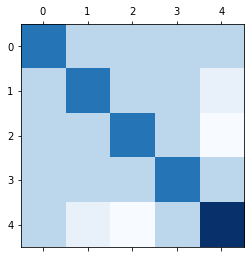

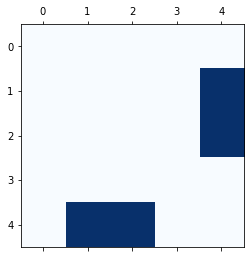

In [9]:
plt.matshow(test0.K, cmap='Blues')
plt.matshow(test0.G, cmap='Blues')

In [10]:
# All in one function
test1 = Simulator(D, V, M, k, gamma, seed=1979)
test1.generate_all_data()
test1.W

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


array([[ 1.,  1.,  1.,  0.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  5.],
       [ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 4.,  4.,  4.,  0.,  3.,  4.,  4.,  8.,  7.,  5.,  2.,  5.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 4.,  1.,  5.,  0.,  7.,  1.,  1.,  5.,  3.,  4.,  1., 10.],
       [10., 10.,  6.,  1.,  6.,  3.,  3.,  6.,  6.,  8.,  1., 10.],
       [ 5.,  1.,  1.,  0.,  4.,  0.,  3.,  6.,  4.,  2.,  1.,  4.],
       [ 8.,  4.,  2.,  1.,  9.,  3.,  4.,  4.,  5.,  0.,  0.,  6.]])

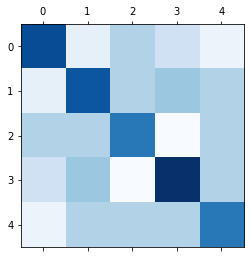

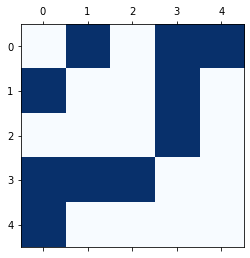

In [11]:
plt.matshow(test1.K, cmap='Blues')
plt.matshow(test1.G, cmap='Blues')

In [12]:
# Confirming that with the same seed and input parameters, data generated are the same
test2 = Simulator(D, V, M, k, gamma, seed=1979)
test2.generate_all_data()
assert np.all(np.equal(test1.W, test2.W))  

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


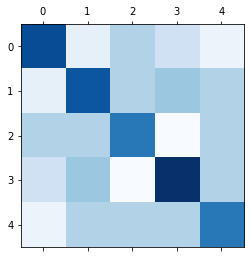

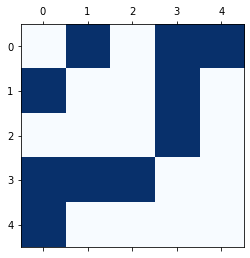

In [13]:
plt.matshow(test2.K, cmap='Blues')
plt.matshow(test2.G, cmap='Blues')

From now on let's use the following simulated data for further testing

In [14]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

# Problem: We need at least matching Ws (?)
# Shouldn't we generate the random initial data starting from W?
# random_initial_data.W = test_data.W
# random_initial_data.Z = sample_Z_from_W(test_data.W, k, seed=1969)
# ...

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


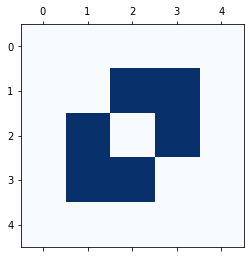

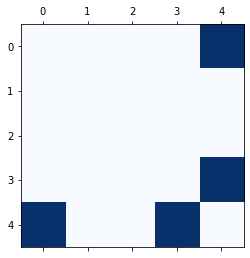

In [15]:
plt.matshow(test_data.G, cmap='Blues')

plt.matshow(random_initial_data.G, cmap='Blues')

# 2 MC SAMPLER

## 2.1.1 MCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [16]:
#def binary_search(sequence, item):
#    begin_index = 0
#    end_index = len(sequence)-1
#    
#    if sequence[begin_index] <= item and item <= sequence[end_index]:
#        while begin_index < end_index - 1:  # Finish when the list has 2 items: Begin and end
#            midpoint = (end_index + begin_index) // 2
#            midpoint_value = sequence[midpoint]
#            if midpoint_value < item:
#                begin_index = midpoint
#            else:
#                end_index = midpoint
#        if sequence[begin_index] == item:
#            return begin_index + 1
#        elif item <= sequence[end_index]:
#            return end_index
#    else:
#        return -1

In [7]:
def MC_sample_Z(Z, W, Theta, B, E, C, debug=False):  # D, k are global variables
    for d in range(D):
        for v in range(V):
            I_di = int(W[d, v])
            for j in range(I_di):
                z_hat = int(Z[d, v, j])
                
                if z_hat != -1:  # Bug fix: Took invalid topics and assigned them
                
                    E[d, z_hat] = max(0, E[d, z_hat]-1)

                    C[z_hat, v] = max(0, C[z_hat, v]-1)

                    Rho = []  # Needs to start from zero to have the interval to fall into topic 1
                    Rho_z = 0
                    #Rho.append(Rho_z)

                    for z in range(k):
                        # Compute the denominator sum
                        C_vk = 0
                        for b in range(V):
                            if b != v:
                                C_vk += C[z, b]
                        # Compute the upper limits of the topic probabilities
                        d_part = E[d, z] + Theta[d, z]
                        z_part = C[z, v] + B[z, v]
                        denom = C_vk + V * B[z, v]
                        prob = d_part * z_part / denom
                        if isinstance(prob, float):  # Check NaN
                            Rho.append(prob)
                        else:
                            Rho.append(Rho_z)
                        
                        if debug and not isinstance(prob, float):  # NaN
                            print('E='+str(E[d, z])+', Theta='+str(Theta[d, z])+', d part is '+str(d_part))
                            print('C='+str(C[z, v])+', B='+str(B[z, v])+', z part is '+str(z_part)+', Cb='+str(C_vk)+', denom is '+str(denom))
                        
                    Rho = Rho / np.sum(Rho, axis=0)

                    #print('Old topic: '+str(z_hat)+' search in: '+str(Rho))

                    #u = np.random.uniform(0, Rho[-1])
                    #z_hat = binary_search(Rho, u) - 1
                    
                    z_hat = np.random.choice(k, 1, p=Rho)

                    E[d, z_hat] += 1
                    C[z_hat, v] += 1
                    Z[d, v, j] = z_hat

                    #print('New topic: '+str(z_hat)+', counter by doc: '+str(E[d, z_hat])+', counter by topic: '+str(C[z_hat, v]))

    # Note that we directly modify Z since the update per topic helps for the next iteration 
    return Z, E, C

## 2.1.2 MCMC Sampling Tests

In [58]:
Z_copy = random_initial_data.Z.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()
E_copy = test_data.E.copy()
C_copy = test_data.C.copy()

Z_copy[0]  # Example

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 4., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

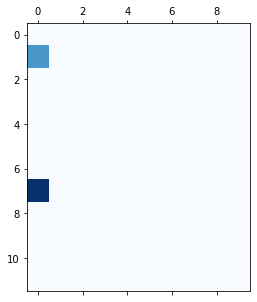

In [59]:
plt.matshow(Z_copy[0], cmap='Blues')

In [60]:
# Check that the function runs with no issues, without side effects but on Z

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy, debug=True)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

# TODO: Review! Should these matrix change? -> Yes since Z is modified
# BUG https://trello.com/c/pWZCzOxq/29-mcsamplez-e-and-c-are-modified
# assert np.all(E_sample == test_data.E) # Triggers
# assert np.all(C_sample == test_data.C) # Triggers

Z_sample[0]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 4., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

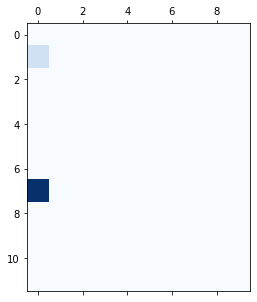

In [61]:
plt.matshow(Z_sample[0], cmap='Blues')

In [70]:
# Binder loss function (FA revised)
# Sum for i < j -> 1 error for each pair that is equal in one and different in the other

def binder_loss(Z_sample, Z_true, debug=False):
    # Input: Z_sample, Z_true matrices -> We only need the cluster indexes
    # Output: err scalar -> Sum of errors
    if Z_sample.shape != Z_true.shape:
        raise Exception('Error: Z matrices of different shape')
    # Idea: Turn matrices into single row to check all pairs more easily
    # First element checks all next elements
    # Get all possible pairs without repeating
    Z_sample_indicator = Z_sample.flatten()
    # Idea: Matrix of differences between rows
    # https://stackoverflow.com/questions/9704565/populate-numpy-matrix-from-the-difference-of-two-vectors
    Z_sample_indicator = np.equal.outer(Z_sample_indicator, Z_sample_indicator)
    # See only equals -> absolute of the difference
    # Eq + Eq -> abs(1-1) = 0 no error
    # Eq + Diff or Diff + Eq -> abs(1-0) = abs(0-1) = 1 error
    # Diff + Diff -> abs(0-0) = 0 no error
    Z_true_indicator = Z_true.flatten()
    Z_true_indicator = np.equal.outer(Z_true_indicator, Z_true_indicator)
    # Now we have the pairwise differences to compare
    error_sum = np.not_equal(Z_sample_indicator, Z_true_indicator).sum() 
    errors = int(error_sum/2)  # We take the entire matrix so the errors are duplicated
    # Max error
    max_err = Z_true_indicator.shape[0] * Z_true_indicator.shape[1]
            
    if debug:
        print('Error: '+str(errors))
        print('Max error: '+ str(max_err))
        print('Error %: '+str(100*errors/max_err))
    return errors/max_err  # Return a percentage to feel better

In [108]:
%%time

# Check that the Sampler works properly (This will take a while)

errors = []
E_errors = []
C_errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    C_sample_old = C_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(binder_loss(Z_sample, test_data.Z))  # Computing error wrt the target distribution
        E_errors.append(np.linalg.norm(E_sample - test_data.E))        
        C_errors.append(np.linalg.norm(C_sample - test_data.C))

The sampled Z has 960 words, while the target Z has 960 words (diff 0)
CPU times: user 2min 37s, sys: 2.27 s, total: 2min 40s
Wall time: 2min 51s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

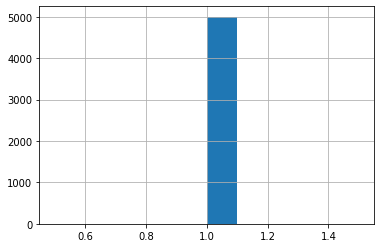

In [109]:
# Matrix should change

matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean        0.218607
std         0.000290
min         0.217744
25%         0.218405
50%         0.218589
75%         0.218788
max         0.219817
dtype: float64


<AxesSubplot:>

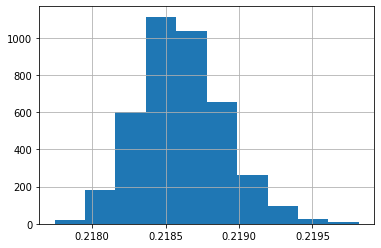

In [110]:
# Error will always be positive and integer, but is it skewed to the left? -> IT IS
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

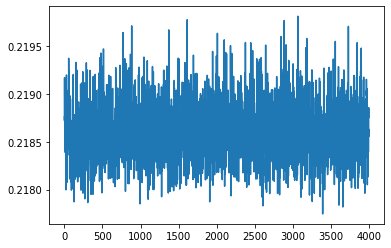

In [111]:
errors.plot()  # See if we still have a caterpillar

E error metrics
count    4000.000000
mean       40.503554
std         2.120189
min        33.301652
25%        39.044844
50%        40.496912
75%        41.988094
max        49.507575
dtype: float64


Text(0.5, 1.0, 'E L2-error distribution')

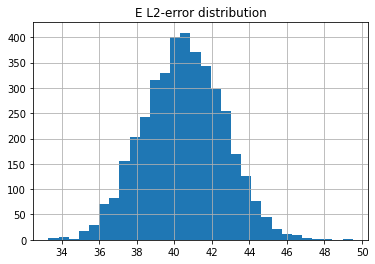

In [112]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target

E_errors = pd.Series(E_errors)
print("E error metrics")
print(E_errors.describe())
E_errors.hist(bins=30)
plt.title('E L2-error distribution')

Text(0.5, 1.0, 'E L2-error series')

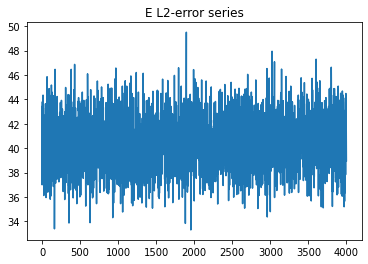

In [113]:
E_errors.plot()
plt.title('E L2-error series')

C error metrics
count    4000.000000
mean       24.725148
std         1.824380
min        19.183326
25%        23.494680
50%        24.617067
75%        25.845696
max        33.763886
dtype: float64


Text(0.5, 1.0, 'C L2-error distribution')

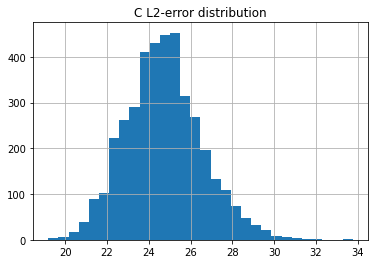

In [114]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
C_errors = pd.Series(C_errors)
print("C error metrics")
print(C_errors.describe())
C_errors.hist(bins=30)
plt.title('C L2-error distribution')

Text(0.5, 1.0, 'C L2-error series')

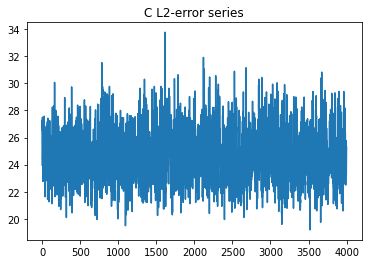

In [115]:
C_errors.plot()
plt.title('C L2-error series')

### Binder loss tests

In [71]:
%%time
# Testing
binder_loss(Z_sample, test_data.Z, debug=True)  # Note that all possible pairs are 460320

Error: 200997
Max error: 921600
Error %: 21.8095703125
CPU times: user 8.15 ms, sys: 3.9 ms, total: 12 ms
Wall time: 12 ms


0.218095703125

In [72]:
%%time
# This MUST return zero
binder_loss(Z_sample, Z_sample, debug=True)

Error: 0
Max error: 921600
Error %: 0.0
CPU times: user 8.27 ms, sys: 2.71 ms, total: 11 ms
Wall time: 31.8 ms


0.0

In [73]:
# Shifting indexes
Z_sample_shifted = Z_sample.copy()
for i in range(k):
    replace_value = (i + 1) % k 
    Z_sample_shifted[Z_sample == i] = replace_value

# This MUST return zero
%time binder_loss(Z_sample, Z_sample_shifted, debug=True)

Error: 0
Max error: 921600
Error %: 0.0
CPU times: user 8.73 ms, sys: 2.86 ms, total: 11.6 ms
Wall time: 13.7 ms


0.0

In [37]:
#def binder_loss_fast(Z_sample, Z_true, debug=False):
    # Input: Z_sample, Z_true matrices -> We only need the cluster indexes
    # Output: err scalar -> Sum of errors
#    if Z_sample.shape != Z_true.shape:
#        raise Exception('Error: Z matrices of different shape')
    # Idea: Turn matrices into single row to check all pairs more easily
    # First element checks all next elements
    # Get all possible pairs without repeating
#    errors = np.zeros((k, k))
#    for t_sample in range(k):  # iterate over sample topics
#        Z_sample_indicator = Z_sample == t_sample
#        for t_true in range(k):  # iterate over true topics
            # See only equals -> absolute of the difference
            # Eq + Eq -> abs(1-1) = 0 no error
            # Eq + Diff or Diff + Eq -> abs(1-0) = abs(0-1) = 1 error
            # Dif + Diff -> abs(0-0) = 0 no error
#            Z_true_indicator = Z_true == t_true
#            error_sum = np.not_equal(Z_sample_indicator, Z_true_indicator).sum() 
#            errors[t_sample][t_true] = error_sum
            
#    if debug:
#        print('Error matrix:')
#        print(errors)
#        print('Error sum:')
#        print(errors.sum())
    # Minimization (Stable Marriage Problem)
#    final_loss = 0
#    matches = []
#    theoretical_max = Z_sample.size  # I will use it as a dummy variable
#    while not len(matches) == k:
#        min_error = np.amin(errors.flatten())  # Select min
#        i, j = np.where(errors == min_error)  # Find index
        # There could be multiple minima, only using the first one
#        i = i[0]
#        j = j[0]
#        if debug:
#            print(f"Sample topic {i} was matched with true topic {j} with error {min_error}")
#        final_loss += min_error
#        matches.append([i, j])
        # Filling corresponding row and column so that those two indexes will not be selected again
#        errors[:,j] = theoretical_max
#        errors[i,:] = theoretical_max
#    return final_loss

In [38]:
#%%time
# This MUST return zero
#binder_loss_fast(Z_sample, Z_sample, debug=True)

Error matrix:
[[  0. 134. 140. 149. 201.]
 [134.   0. 122. 131. 183.]
 [140. 122.   0. 137. 189.]
 [149. 131. 137.   0. 198.]
 [201. 183. 189. 198.   0.]]
Error sum:
3168.0
Sample topic 0 was matched with true topic 0 with error 0.0
Sample topic 1 was matched with true topic 1 with error 0.0
Sample topic 2 was matched with true topic 2 with error 0.0
Sample topic 3 was matched with true topic 3 with error 0.0
Sample topic 4 was matched with true topic 4 with error 0.0
Wall time: 6.01 ms


0.0

In [39]:
# Shifting indexes
#Z_sample_shifted = Z_sample.copy()
#for i in range(k):
#    replace_value = (i + 1) % k 
#    Z_sample_shifted[Z_sample == i] = replace_value

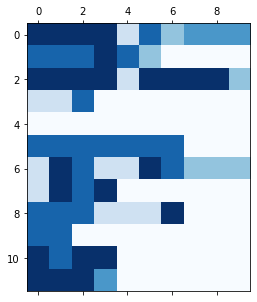

In [40]:
#plt.matshow(Z_sample[2], cmap='Blues')

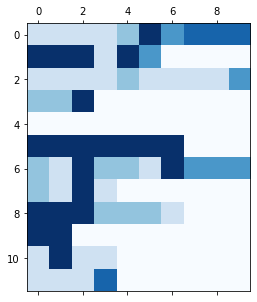

In [41]:
#plt.matshow(Z_sample_shifted[2], cmap='Blues')

In [42]:
#%%time
# This MUST return zero
#binder_loss_fast(Z_sample, Z_sample_shifted, debug=True)

Error matrix:
[[201.   0. 134. 140. 149.]
 [183. 134.   0. 122. 131.]
 [189. 140. 122.   0. 137.]
 [198. 149. 131. 137.   0.]
 [  0. 201. 183. 189. 198.]]
Error sum:
3168.0
Sample topic 0 was matched with true topic 1 with error 0.0
Sample topic 1 was matched with true topic 2 with error 0.0
Sample topic 2 was matched with true topic 3 with error 0.0
Sample topic 3 was matched with true topic 4 with error 0.0
Sample topic 4 was matched with true topic 0 with error 0.0
Wall time: 4 ms


0.0

In [43]:
#%%time
#binder_loss_fast(Z_sample, test_data.Z, debug=True)

Error matrix:
[[121. 151. 111. 111. 165.]
 [117. 125. 107.  99. 151.]
 [113. 145.  99. 107. 159.]
 [128. 138. 108.  98. 142.]
 [178. 198. 164. 146. 152.]]
Error sum:
3333.0
Sample topic 3 was matched with true topic 3 with error 98.0
Sample topic 2 was matched with true topic 2 with error 99.0
Sample topic 1 was matched with true topic 0 with error 117.0
Sample topic 0 was matched with true topic 1 with error 151.0
Sample topic 4 was matched with true topic 4 with error 152.0
Wall time: 5 ms


617.0

In [44]:
#binder_loss(Z_sample[1], test_data.Z[1])

716.0

In [45]:
#binder_loss_fast(Z_sample[1], test_data.Z[1], debug=True)

Error matrix:
[[16. 10. 14.  6. 11.]
 [14.  6. 16.  6. 11.]
 [14. 12. 16.  8. 13.]
 [12.  6. 14.  2.  9.]
 [16. 12. 14.  8. 13.]]
Error sum:
279.0
Sample topic 3 was matched with true topic 3 with error 2.0
Sample topic 1 was matched with true topic 1 with error 6.0
Sample topic 0 was matched with true topic 4 with error 11.0
Sample topic 2 was matched with true topic 0 with error 14.0
Sample topic 4 was matched with true topic 2 with error 14.0


47.0

In [46]:
#%%time
# Check that the Sampler works properly
#errors = []

#burn_in = 1000
#for i in range(5000):
#    Z_sample_old = Z_sample.copy()
#    E_sample_old = E_sample.copy()
#    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
#    if i >= burn_in:
#        errors.append(binder_loss_fast(Z_sample, test_data.Z))  # Computing Binder loss

Wall time: 2min 54s


Z error metrics
count    4000.00000
mean      588.34300
std        16.03024
min       541.00000
25%       575.00000
50%       589.00000
75%       601.00000
max       659.00000
dtype: float64


Text(0.5, 1.0, 'Z Binder-fast-error distribution')

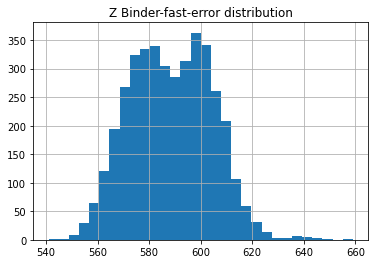

In [47]:
# Error will always be positive and integer, but is it skewed to the left?
#errors = pd.Series(errors)
#print("Z error metrics")
#print(errors.describe())
#errors.hist(bins=30)
#plt.title('Z Binder-fast-error distribution')

Text(0.5, 1.0, 'Z Binder-fast-error series')

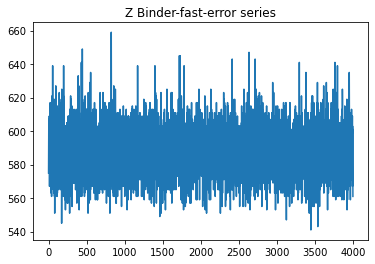

In [48]:
#errors.plot()  # See if we still have a caterpillar
#plt.title('Z Binder-fast-error series')

## 2.2.1 Beta sampling

### Task:

You must implement a function that receives matrices $C_i$ and vector $\alpha$ and generates the next $B_{i+1}$.

In [8]:
def MC_sample_B(alpha, C):
    # B, C are (k, V) -> Generate k vectors
    B = np.random.dirichlet(alpha + C[0,:], size=1)  # Topic 0
    for i in range(C.shape[0]-1):  # Go through topics: Fix is excluding topic 0 already generated
        B = np.concatenate((B, np.random.dirichlet(alpha + C[i+1,:], size=1)), axis=0)
    return B

## 2.2.2 Beta sampling tests

In [77]:
# Check that the function runs with no issues, without side effects
alpha = np.ones(V)
C_copy = test_data.C.copy()

B_sample = MC_sample_B(alpha, C_copy)

assert np.all(C_copy == test_data.C)

In [78]:
B_sample.shape  # k, V -> Fixed

(5, 12)

In [116]:
%%time
# Check that the Sampler works properly (This will take a while)
Berrors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled B has {B_sample.size} words, while the target B has {test_data.B.size} words (diff {abs(B_sample.size-test_data.B.size)})')
for i in range(5000):
    B_sample_old = B_sample.copy()
    B_sample = MC_sample_B(alpha, C_copy)
    matrix_changes.append(~np.all(B_sample_old == B_sample))
    if i >= burn_in:
        err_by_it = []
        for topic in range(k):
            err_by_it.append(np.linalg.norm(B_sample[topic] - test_data.B[topic]))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch
        Berrors.append(err_by_it)

The sampled B has 60 words, while the target B has 60 words (diff 0)
CPU times: user 1.17 s, sys: 38.5 ms, total: 1.2 s
Wall time: 1.35 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

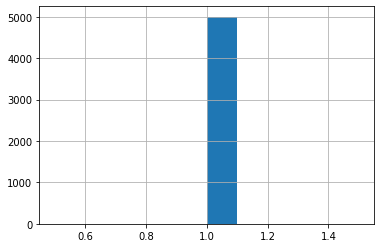

In [117]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

B L2-error metrics
                 0            1            2            3            4
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000
mean      0.142775     0.116591     0.141051     0.170262     0.116657
std       0.023598     0.020922     0.029607     0.031391     0.021531
min       0.059646     0.038036     0.051297     0.065408     0.042355
25%       0.126705     0.103303     0.120679     0.148414     0.101673
50%       0.142084     0.116581     0.139172     0.168875     0.115578
75%       0.157219     0.129987     0.159022     0.190244     0.130459
max       0.255924     0.197759     0.254316     0.306479     0.212436


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

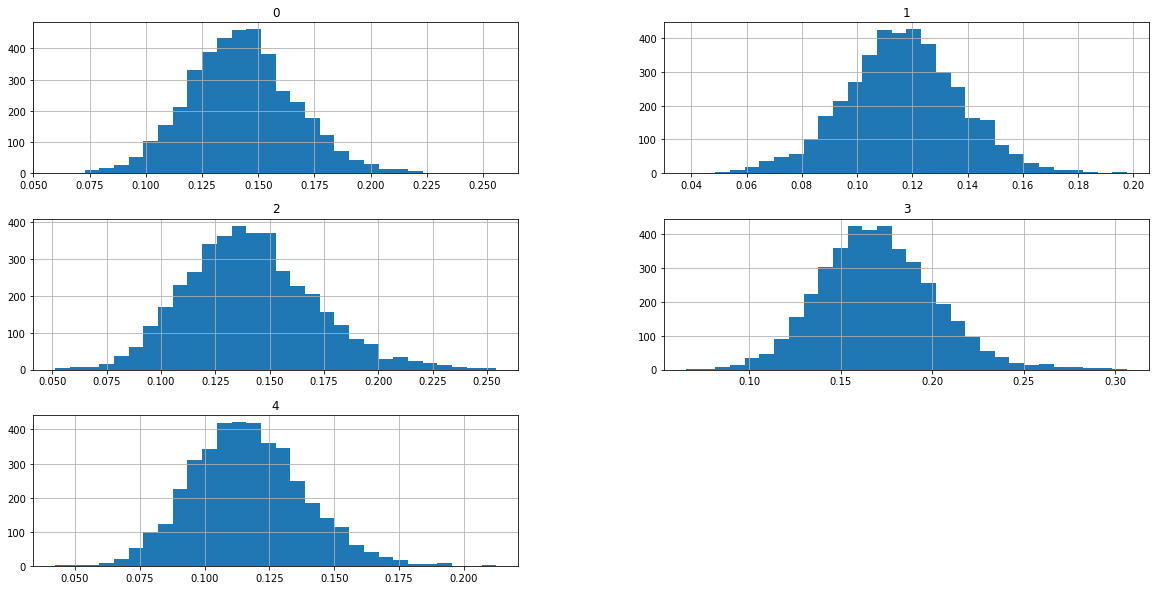

In [119]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.DataFrame(Berrors)
print("B L2-error metrics")
print(errors.describe())
errors.hist(bins=30, layout=(3,2), figsize=(20, 10))

Text(0.5, 1.0, 'B L2-error series')

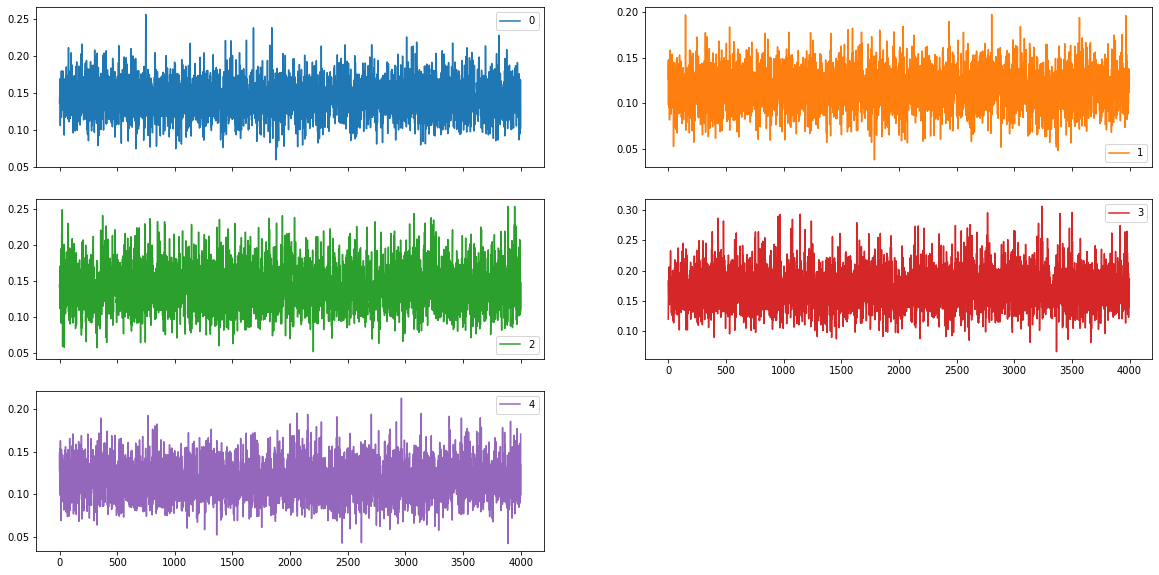

In [121]:
errors.plot(subplots=True, layout=(3,2), figsize=(20, 10))
plt.title('B L2-error series')

## 2.3.1 Metropolis-Hastings MC Sampling

### Task:

You must implement a function that receives matrices $E_i$, $K_i$ and vector $\mu$ and generates the next $H_{i+1}$.


. $E$ matrix of $D \times k$ where $E_d$ is the $k$-dim vector of counts of sampled drawings for the $z$-th topic over all words for each document

. $K$ matrix of $k \times k$ representing the precision matrix associated to the graph $G$

. $\mu = 0$

. $H$ matrix of $D \times k$ where $H_d = \eta_d$ is the $k$-dim vector of the topic prevalences over document $d$

In [9]:
import numpy as np
import numpy.linalg

In [10]:
# Argument of the exponential in the kernel numerator
def log_kernel_numerator(eta, K, E):
    k = eta.shape[0]
    eta_K_eta = -0.5 * (eta.dot(K)).dot(eta)
    E_eta = E.dot(eta)
    return eta_K_eta + E_eta

# Kernel denominator
def sum_eta(eta):
    #k = eta.shape[0]
    sum_eta = np.sum(np.exp(eta))
    return sum_eta

In [11]:
#def sampled_distribution_kernel(eta, K, E):
#    k = eta.shape[0]
#    eta_K_eta = -0.5 * eta.dot(K.dot(eta))
#    E_eta = E.dot(eta)
#    sum_eta_pow_k = np.sum(np.exp(eta)) ** k
#    return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706

In [12]:
def MC_sample_H(E, Sigma, H_current=None, burn_in=0, seed=None):
    
    np.random.seed(seed)
    
    K = np.linalg.inv(Sigma)
    
    D, k = E.shape  # Number of documents, Number of topics
    
    if H_current is None:
        H_current = np.zeros((D, k))
    
    H_sampled = np.zeros((D, k))
    
    mean=np.zeros((k,))
    Cov=0.25*np.identity(k)
    
    for d in range(D):  # Iterating over each document
        
        E_d = E[d]
        
        for it in range(burn_in+1):
            current_eta = H_current[d]        
            
            # Sampling proposed eta from multivariate normal (q "proposal density")
            #proposed_eta = np.random.multivariate_normal(mean, Sigma) 

            #Other option:           
            proposed_eta = np.random.multivariate_normal(mean, Cov)
            
            #Logarithm of the kernel numerator
            lkn_proposed_eta = log_kernel_numerator(proposed_eta, K, E_d)
            lkn_current_eta = log_kernel_numerator(current_eta, K, E_d)
            
            #Logarithm of the kernel denominator
            lkd_proposed_eta=k*np.log(sum_eta(proposed_eta))
            lkd_current_eta=k*np.log(sum_eta(current_eta))

            #Logarithm of the proportion
            log_p_proportion=(lkn_proposed_eta+lkd_current_eta)-(lkd_proposed_eta+lkn_current_eta)

            alpha = min(0, log_p_proportion)

            if np.log(np.random.uniform(0.0, 1.0)) < alpha:
                current_eta = proposed_eta

            H_sampled[d] = current_eta
    
    return H_sampled

## 2.3.2 MH Sampling Tests

In [15]:
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()

H_sample = MC_sample_H(E_copy, Sigma_copy)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

In [24]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000

for i in range(5000):
    H_sample_old = H_sample.copy()
    H_sample = MC_sample_H(E_copy, Sigma_copy, H_sample_old, burn_in=10)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix

CPU times: user 3min 5s, sys: 15.9 s, total: 3min 21s
Wall time: 1min 47s


Matrix changes (1 = changed, 0 = same)
count    5000.000000
mean        0.429600
std         0.495069
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64


<AxesSubplot:>

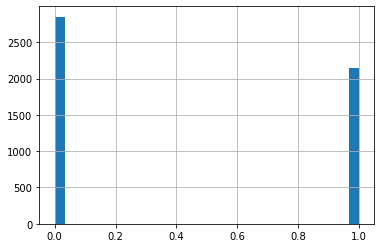

In [25]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    4000.000000
mean        6.818199
std         0.155465
min         6.437403
25%         6.703055
50%         6.807022
75%         6.926909
max         7.496033
dtype: float64


<AxesSubplot:>

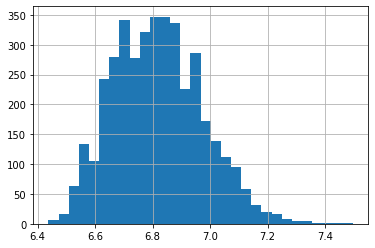

In [26]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


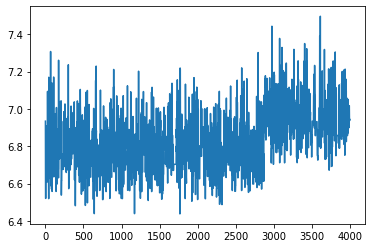

In [27]:
errors.plot()
print("H L2-error series")

In [28]:
def compute_Theta(H):
    D, k = H.shape
    update = np.zeros((D, k))
    for d in range(D):
        update[d] = scipy.special.softmax(H[d])
    return update

As you can see, the true (left) and the last sampled (center) $\Theta$ are quite similar. The right heatmap represents the difference of the first two. 


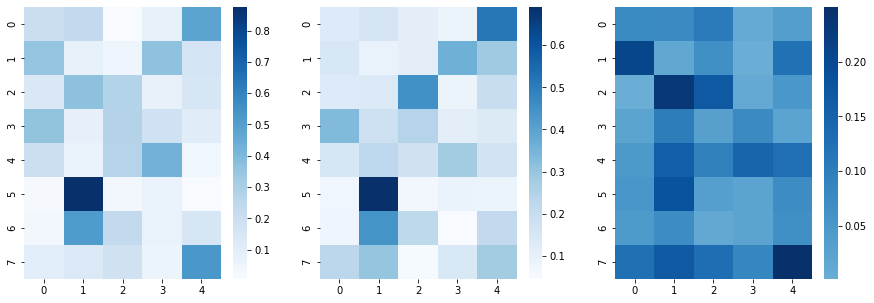

0.6722789731548005

In [37]:
import seaborn as sn
import sklearn

fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = compute_Theta(H_sample)
true_Theta = compute_Theta(test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta-last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)

## 2.4.1 BDMCMC Sampling

In [22]:
import subprocess

def serialize_matrix(m):
    if len(m.shape) != 2:
        raise Exception("Can not serialize ill-shaped matrix!")
    res = '\n'.join(' '.join(str(entry) for entry in row)  # Space between entries, newline between rows
                     for row in m)
    return '"' + res + '"'

def deserialize_matrix(line, shape, separator=' '):
    return np.fromstring(line, sep=separator).reshape(shape)

#### Serialization test

In [90]:
# This function is only used to test if the serialization and deserialization functions between R and python work properly
def serialization_function_test(n_tests=200, shape=(8,17)):    
    results = []
    for _ in range(n_tests):
        
        # Generate random matrix
        test_matrix = np.random.random(shape) * 100
        
        # Serialize matrix
        serialized_test_matrix = serialize_matrix(test_matrix)
        
        # Send to R script
        command = f"Rscript --vanilla serialize_matrix_test.R {serialized_test_matrix}"
        result = subprocess.run(command, 
                                shell=True, 
                                capture_output=True,
                                text=True)
        
        # Deserialize from R output
        deserialized_test_matrix = deserialize_matrix(result.stdout, shape=shape)
        differences = np.abs(test_matrix-deserialized_test_matrix)
        max_diff = np.max(differences)
        min_diff = np.min(differences)
        diff_sum = np.sum(differences)
        results.append({'max_diff': max_diff, 'min_diff': min_diff, 'diff_sum': diff_sum})
    return pd.DataFrame(results)

In [91]:
test_result_df = serialization_function_test()
test_result_df.head()

,max_diff,min_diff,diff_sum
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [92]:
test_result_df.describe()

,max_diff,min_diff,diff_sum
count,2.000000e+02,200.0,2.000000e+02
mean,7.105427e-17,0.0,7.105427e-17
std,7.087552e-16,0.0,7.087552e-16
min,0.000000e+00,0.0,0.000000e+00
25%,0.000000e+00,0.0,0.000000e+00
50%,0.000000e+00,0.0,0.000000e+00
75%,0.000000e+00,0.0,0.000000e+00
max,7.105427e-15,0.0,7.105427e-15


### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [23]:
def MC_sample_GK(G, H, degrees_of_freedom_b, debug=False):
    size = G.shape[0]
    n = H.shape[0]
    
    # Serialize the inputs
    G = serialize_matrix(G)
    
    # Transform H into the BDGraph data matrix
    data_matrix = H.T.dot(H)
    data_matrix = serialize_matrix(data_matrix)
    
    # call R script using python.subprocess
    # The parameter order is: deg.of freedom b, 
    #                         number of data samples (documents) n, 
    #                         graph adjacency matrix G, 
    #                         data matrix,
    #                         debug ("TRUE" or "FALSE"), 
    command = f"Rscript --vanilla bdmcmc.R {degrees_of_freedom_b} {n} {G} {data_matrix} {'TRUE' if debug else 'FALSE'}"
    result = subprocess.run(command, 
                            shell=True, 
                            capture_output=True,
                            text=True)
    
    if result.returncode != 0:  # Something went wrong
        print(result.stdout)
        print(result.stderr)
        raise Exception("Rscript error! Check the previous logs for more details")
    
    if debug:
        print(result.stdout)
    
    # The last two lines of the R output MUST be the sampled matrices
    lines = result.stdout.rsplit('\n', 3)  # Split only the last three lines  https://www.w3schools.com/python/ref_string_rsplit.asp
    waiting_time = float(lines[-3])  # 3rd from the end
    G = deserialize_matrix(lines[-2], shape=(size, size))  # Line before last
    K = deserialize_matrix(lines[-1], shape=(size, size))  # Last line
    return waiting_time, G, K

## 2.4.2 BDMCMC Sampling Tests

#### MC_sample_GK tests

In [93]:
# Check that the function runs with no issues, without side effects
G_copy = random_initial_data.G.copy()
H_copy = test_data.H.copy()
degrees_of_freedom_b = k - 1
shape_matrix = np.eye(k)

wt_sample, G_sample, K_sample = MC_sample_GK(G_copy, H_copy, degrees_of_freedom_b, debug=True)

# assert np.all(W_copy == test_data.W)
# assert np.all(Z_copy == test_data.Z)
# assert np.all(H_copy == test_data.H)
# assert np.all(K_copy == test_data.K)
# assert np.all(E_copy == test_data.E)
# assert np.all(shape_matrix == np.eye(k))

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  0  0  1
[2,]  0  0  0  0  0
[3,]  0  0  0  0  0
[4,]  0  0  0  0  1
[5,]  1  0  0  1  0
[1] "[R] Data Matrix:"
             V1        V2          V3          V4         V5
[1,]  4.8271696 -2.529908 -2.60905613  2.06795435  0.9204163
[2,] -2.5299083 20.108788  1.69769232  1.36241338  1.0238644
[3,] -2.6090561  1.697692 10.93384050 -0.01653776 -4.1524335
[4,]  2.0679544  1.362413 -0.01653776  4.42360858 -3.7338783
[5,]  0.9204163  1.023864 -4.15243354 -3.73387834  7.9064371
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1
[1] "[R] Iterations:"
[1] 2
  This OS does not support multi-threading for the BDgraph package  
2 iteration is started.                     
 Iteration  2                 
[1] "[R] Waiting time:"
[1] 1.090476
[1] "[R] Sampled Matrix G:"
   V1 V2 V3 V4 V5
V1  0  0  0

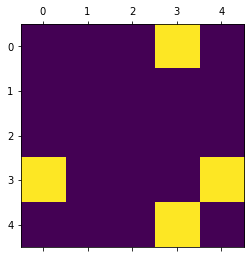

In [94]:
plt.matshow(G_sample)  # Why is this NOT symmetric?

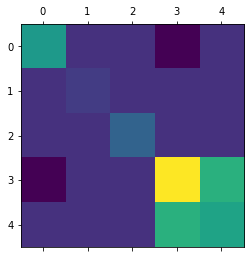

In [95]:
plt.matshow(K_sample)  # Why is this NOT a mask of G?

In [96]:
%%time
# Check that the Sampler works properly (This will take... forever)
K_errors = []
G_errors = []
matrix_changes = []
burn_in = 0
for i in range(1000):
    K_sample_old = K_sample.copy()
    G_sample_old = G_sample.copy()
    wt_sample, G_sample, K_sample = MC_sample_GK(G_sample, H_copy, degrees_of_freedom_b, debug=False)
    matrix_changes.append(~np.all(K_sample_old == K_sample))
    if i >= burn_in:
        K_errors.append(np.linalg.norm(K_sample - test_data.K))  # Computing error wrt the target matrix        
        G_errors.append(np.linalg.norm(G_sample - test_data.K))  # Computing error wrt the target matrix

CPU times: user 2.47 s, sys: 7 s, total: 9.47 s
Wall time: 6min 13s


Matrix changes (1 = changed, 0 = same)
count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

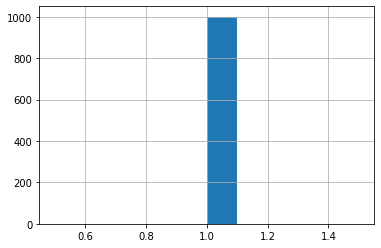

In [97]:
# K matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

K L2-error metrics
count    4000.000000
mean        6.560576
std         0.275543
min         5.960091
25%         6.370241
50%         6.523353
75%         6.698816
max         7.554704
dtype: float64


<AxesSubplot:>

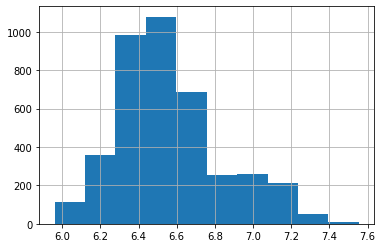

In [98]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
K_errors = pd.Series(errors)
print("K L2-error metrics")
print(K_errors.describe())
K_errors.hist()

K L2-error series


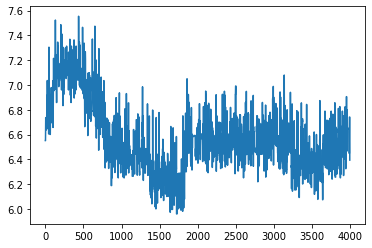

In [99]:
K_errors.plot()
print("K L2-error series")

G L2-error metrics
count    4000.000000
mean        6.560576
std         0.275543
min         5.960091
25%         6.370241
50%         6.523353
75%         6.698816
max         7.554704
dtype: float64


<AxesSubplot:>

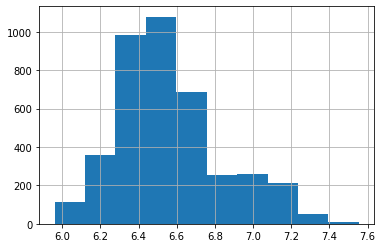

In [100]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
G_errors = pd.Series(errors)
print("G L2-error metrics")
print(G_errors.describe())
G_errors.hist()

G L2-error series


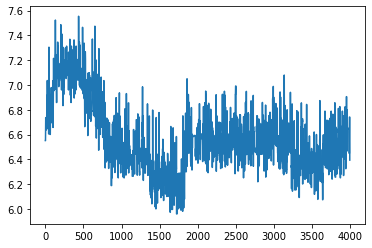

In [101]:
G_errors.plot()
print("G L2-error series")

# MAIN ALGORITHM

### Generating Data

In [38]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [39]:
# Input Data:
simulated_data.W

array([[ 7., 10.,  0.,  9.,  3.,  5.,  1.,  7.,  4.,  1.,  8.,  5.],
       [ 8., 10.,  0.,  8.,  8., 10.,  0.,  4.,  7.,  1.,  5.,  7.],
       [ 0.,  8.,  0.,  4.,  6.,  4.,  0.,  2.,  1.,  1.,  3.,  2.],
       [ 2.,  5.,  1.,  4.,  5.,  6.,  1.,  7.,  8.,  1.,  5.,  0.],
       [10., 10.,  1., 10.,  9., 10.,  0.,  5.,  4.,  1.,  6.,  6.],
       [ 7.,  8.,  0.,  9.,  4.,  5.,  0.,  3.,  3.,  3.,  4.,  2.],
       [ 7., 10.,  0.,  8.,  9., 10.,  0.,  8.,  4.,  2.,  7.,  3.],
       [ 5.,  7.,  1.,  5.,  4.,  7.,  0.,  6.,  3.,  0.,  9.,  3.]])

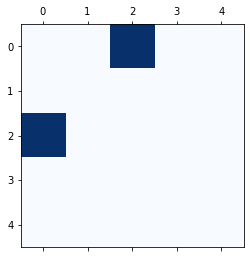

In [40]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

### Sampler

In [41]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: G transformed from K


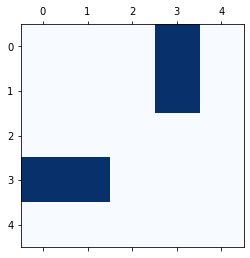

In [42]:
# Initial graph
plt.matshow(initial.G, cmap='Blues')

### Test without Z sampler

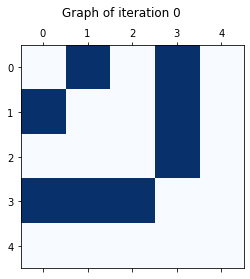

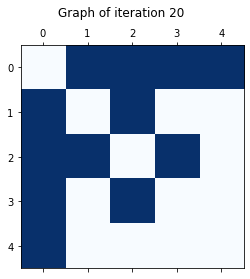

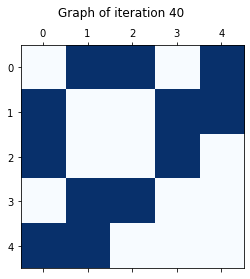

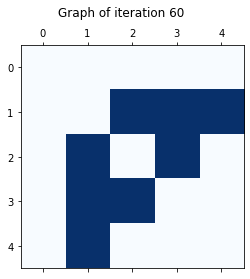

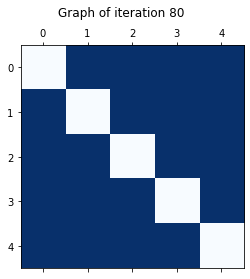

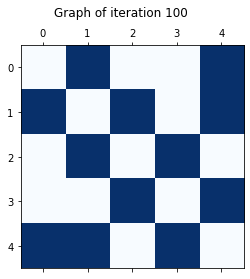

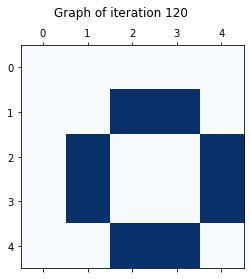

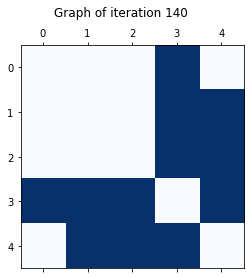

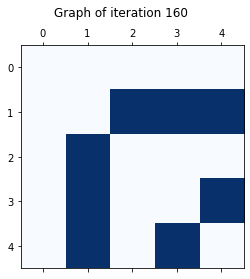

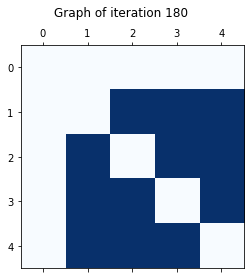

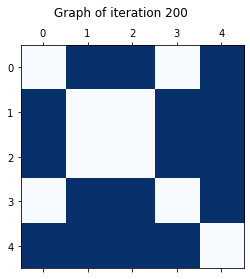

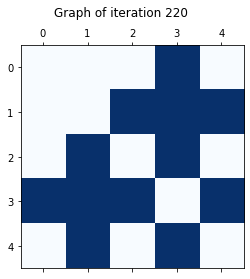

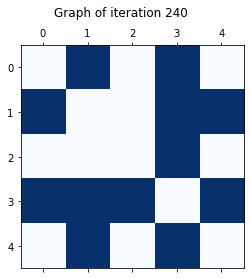

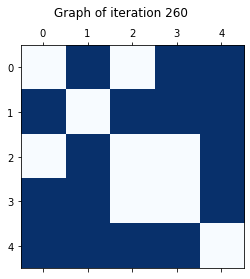

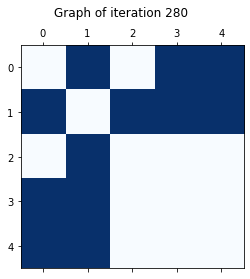

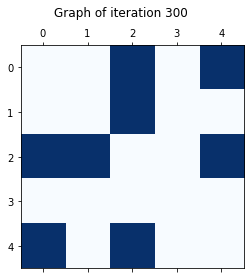

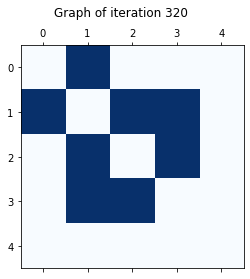

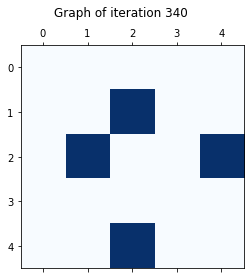

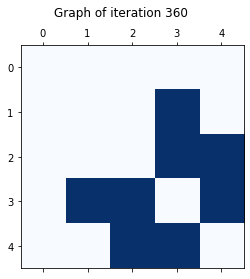

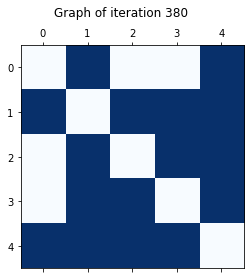

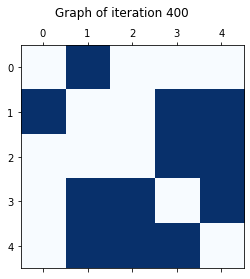

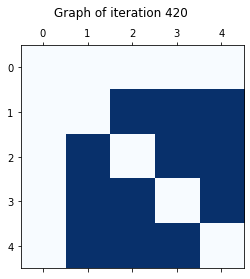

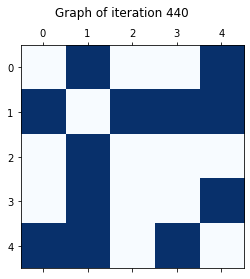

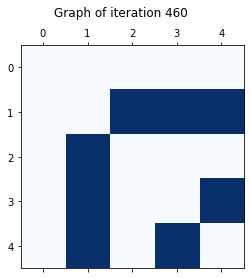

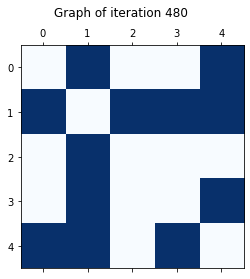

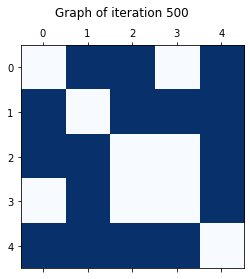

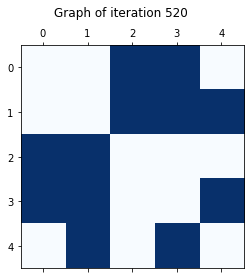

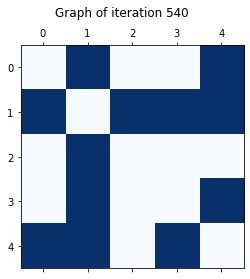

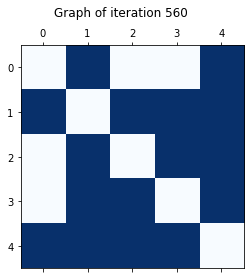

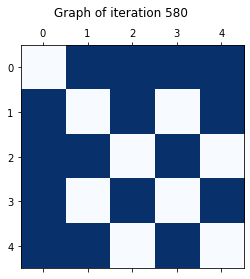

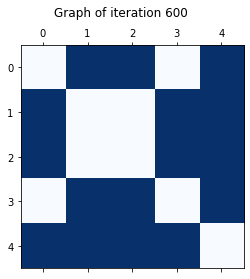

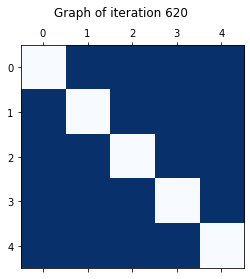

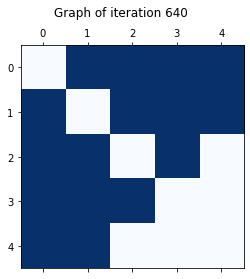

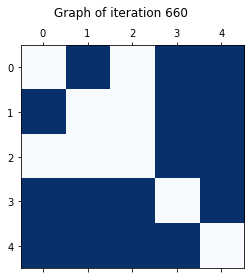

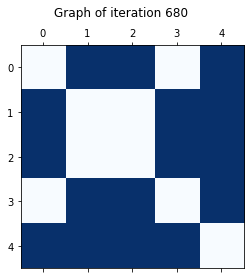

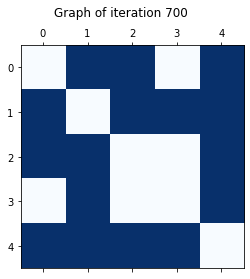

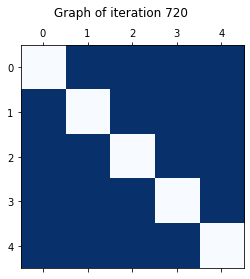

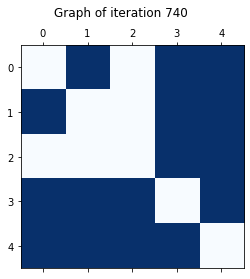

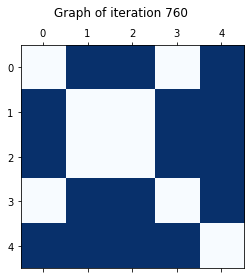

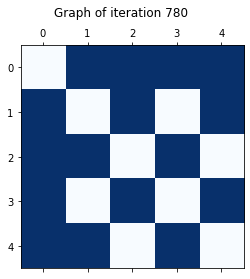

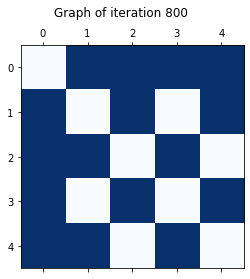

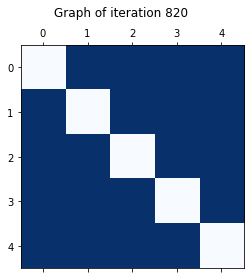

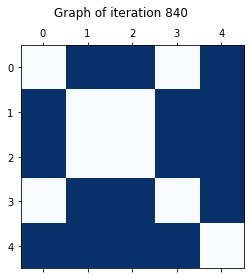

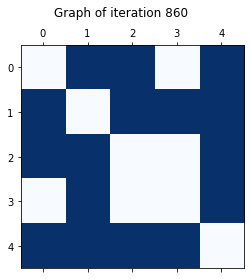

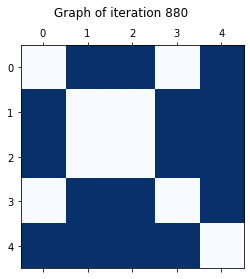

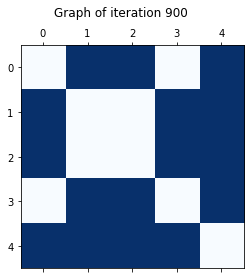

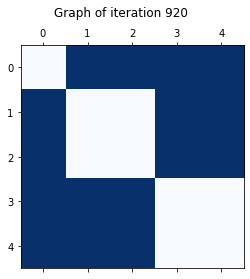

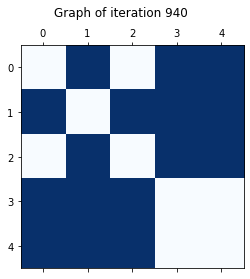

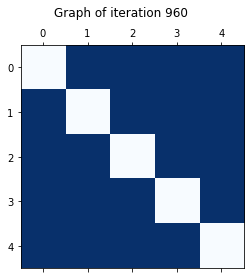

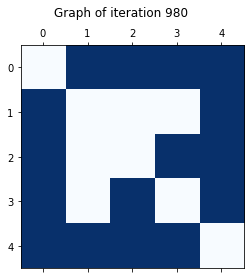

CPU times: user 1min 7s, sys: 15.9 s, total: 1min 23s
Wall time: 6min 59s


In [44]:
%%time
max_iterations = 1000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

G_target = np.triu(simulated_data.G)  # BDgraph always returns upper triangular matrix. Our target matrix should be the same

alpha = np.ones(V)  # Uninformative prior
b = k - 1

# Skipping part
Z = simulated_data.Z.copy()
E = simulated_data.E.copy()
C = simulated_data.C.copy()

H = None

waiting_times = []
sampled_Gs = []
edges_log = []
errors_log = []
graph_changes = []

for iteration in range(max_iterations):
    
    # Step 1
    #Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma, H_current=H, burn_in=10)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    wrong_edges = np.sum(G != G_target)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration%20==0:  # Plot every 20 iterations
        plt.matshow(G, cmap='Blues')
        plt.suptitle("Graph of iteration "+str(iteration), x=0.5, y=1, ha='center')
        plt.show()

Wrong edges metrics
count    1000.000000
mean       14.182000
std         3.139543
min         5.000000
25%        13.000000
50%        15.000000
75%        17.000000
max        19.000000
dtype: float64


Text(0.5, 1, 'G wrong edges histogram')

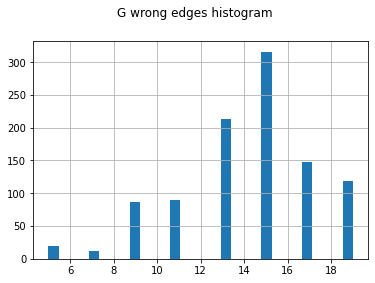

In [45]:
wrong_edges = pd.Series(edges_log)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'Wrong edges series'}>

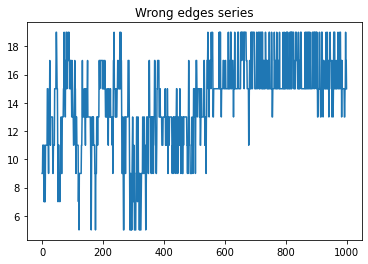

In [46]:
wrong_edges.plot(title="Wrong edges series")

Sigma errors metrics
count    1000.000000
mean       24.780668
std        14.145297
min         2.462205
25%        15.383760
50%        22.044766
75%        31.096182
max       125.022967
dtype: float64


Text(0.5, 1, 'Sigma L2-errors histogram')

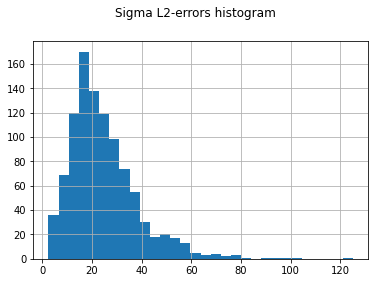

In [47]:
Sigma_errors = pd.Series(errors_log)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'Sigma L2-errors series'}>

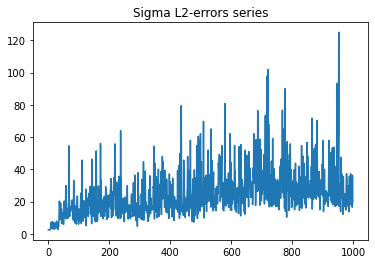

In [48]:
Sigma_errors.plot(title="Sigma L2-errors series")

<AxesSubplot:title={'center':'Waiting times series'}>

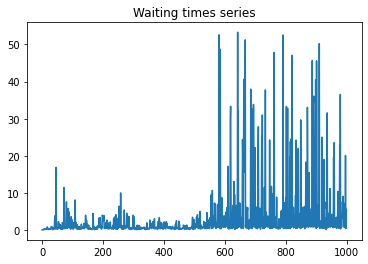

In [49]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")

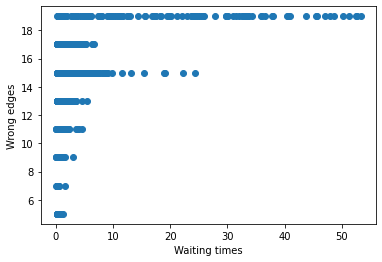

In [50]:
plt.scatter(wait_times, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

G matrix changes (1 = changed, 0 = same)
count    1000.000000
mean        0.711000
std         0.453525
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Text(0.5, 1, 'Graph changes histogram (1 = changed, 0 = same)')

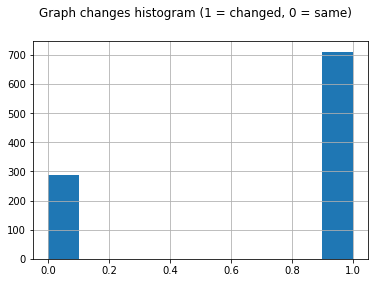

In [51]:
matrix_changes = pd.Series(graph_changes).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'G changes series'}>

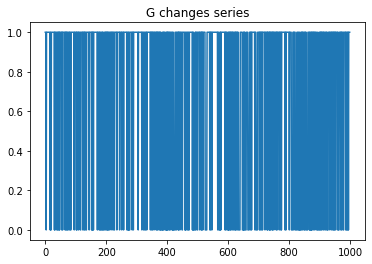

In [52]:
matrix_changes.plot(title='G changes series')

### Test without B sampler

Success: E transformed from Z
Success: C transformed from Z


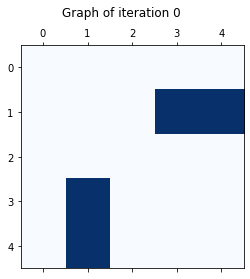

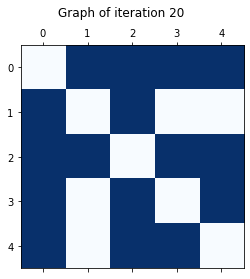

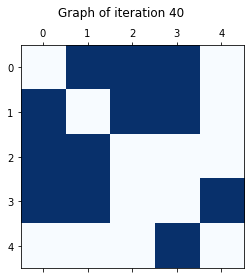

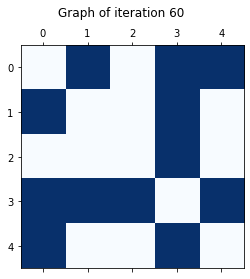

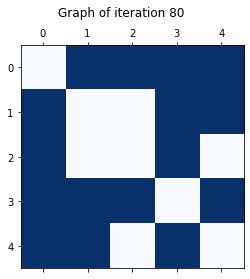

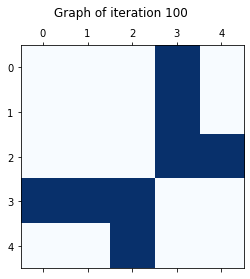

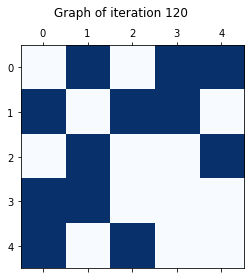

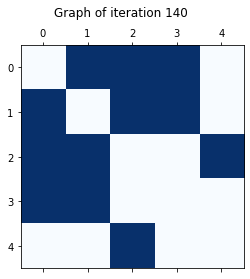

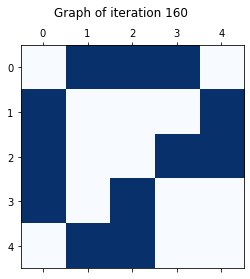

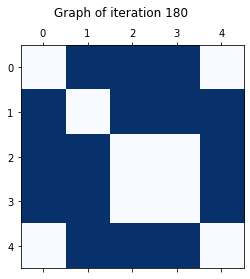

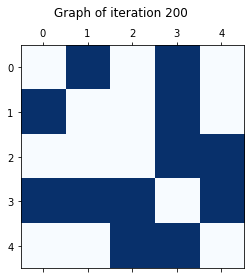

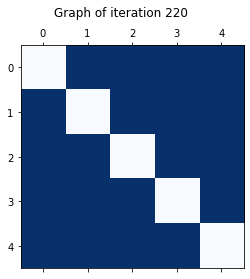

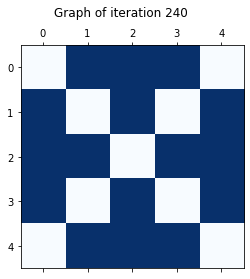

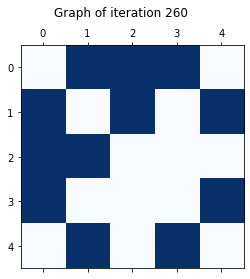

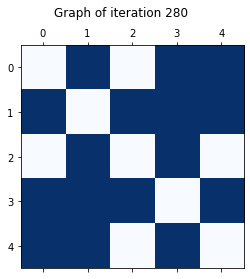

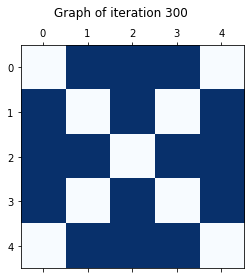

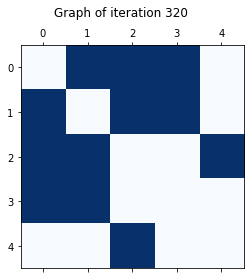

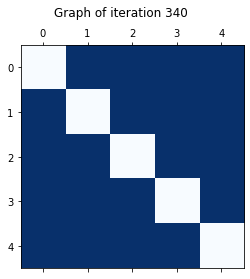

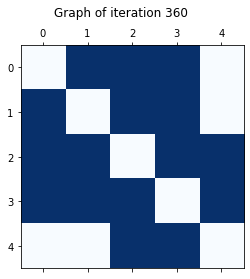

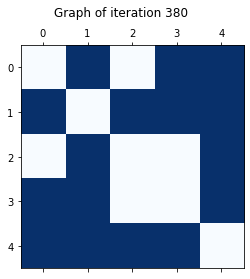

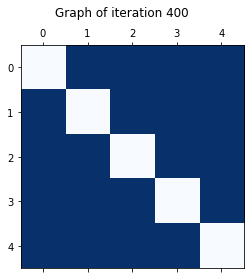

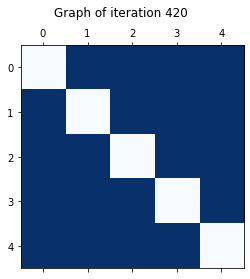

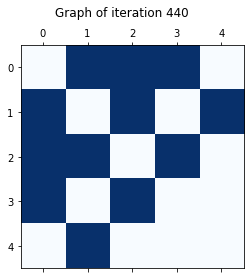

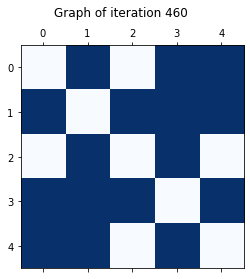

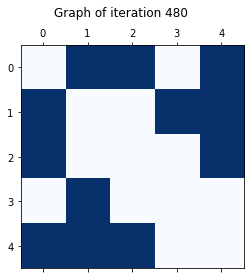

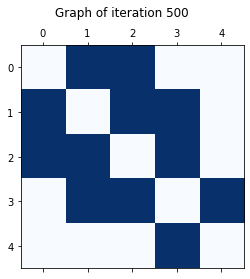

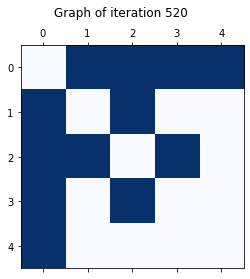

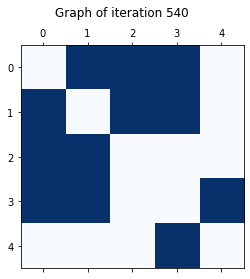

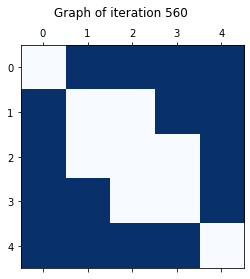

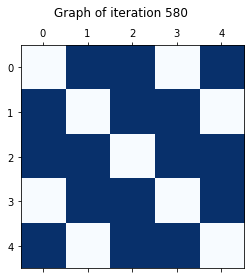

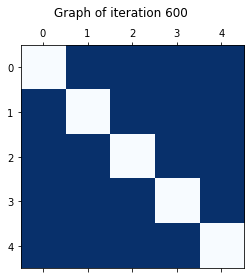

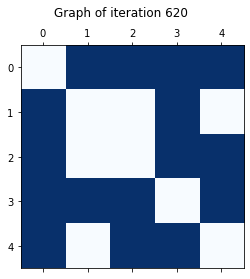

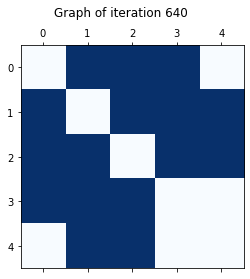

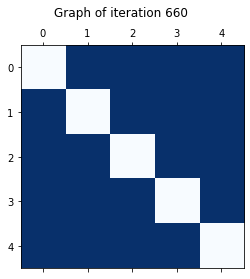

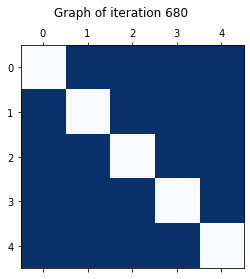

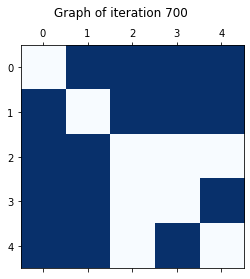

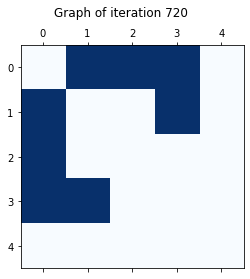

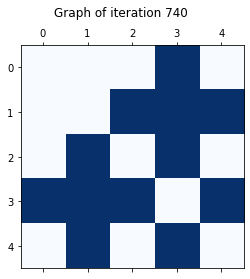

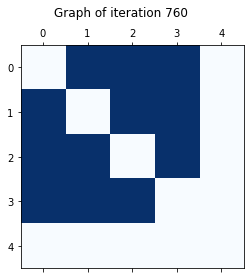

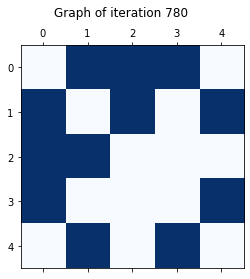

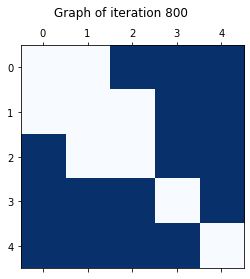

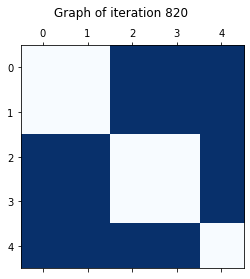

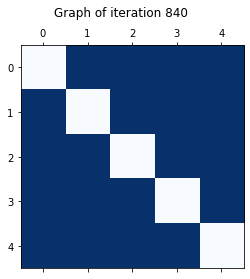

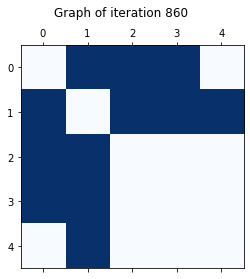

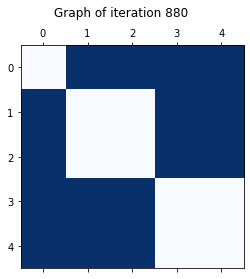

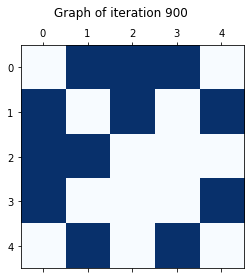

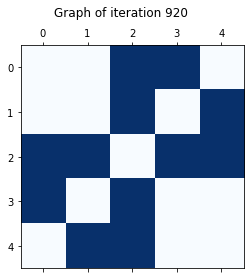

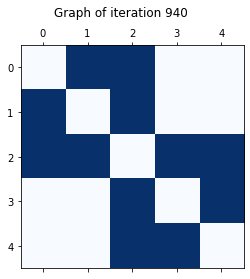

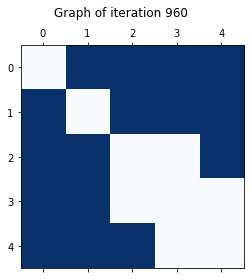

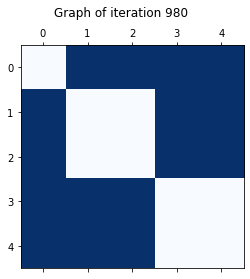

CPU times: user 3min 30s, sys: 29.5 s, total: 4min
Wall time: 8min 6s


In [53]:
%%time
max_iterations = 1000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
Theta = initial.Theta.copy()
G = initial.G.copy()

G_target = np.triu(simulated_data.G)  # BDgraph always returns upper triangular matrix. Our target matrix should be the same

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

H = None

# Skipping part
B = simulated_data.B.copy()

waiting_times = []
sampled_Gs = []
edges_log = []
errors_log = []
graph_changes = []

for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    #B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma, H_current=H, burn_in=10)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    wrong_edges = np.sum(G != G_target)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration%20==0:  # Plot every 20 iterations
        plt.matshow(G, cmap='Blues')
        plt.suptitle("Graph of iteration "+str(iteration), x=0.5, y=1, ha='center')
        plt.show()

Wrong edges metrics
count    1000.000000
mean       13.758000
std         3.281494
min         3.000000
25%        11.000000
50%        15.000000
75%        15.000000
max        19.000000
dtype: float64


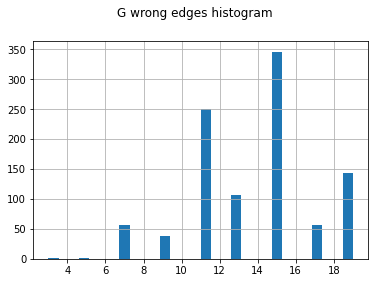

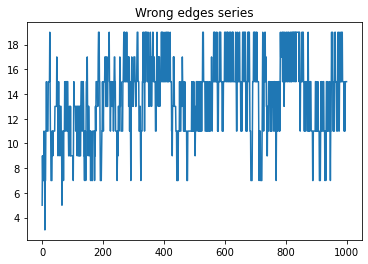

In [54]:
wrong_edges = pd.Series(edges_log)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')
plt.show()

wrong_edges.plot(title="Wrong edges series")
plt.show()

Sigma errors metrics
count    1000.000000
mean       31.213052
std        20.010810
min         2.197365
25%        18.158826
50%        26.977952
75%        38.060253
max       167.153709
dtype: float64


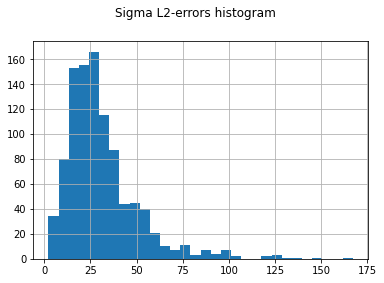

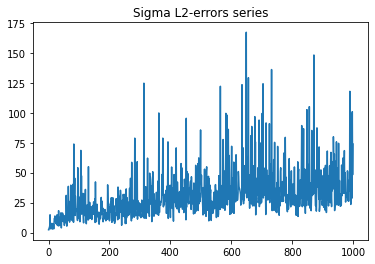

In [55]:
Sigma_errors = pd.Series(errors_log)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')
plt.show()

Sigma_errors.plot(title="Sigma L2-errors series")
plt.show()

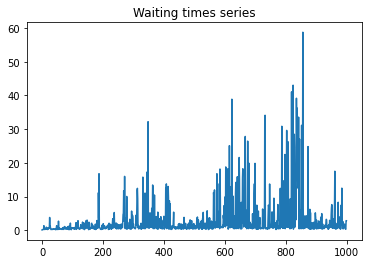

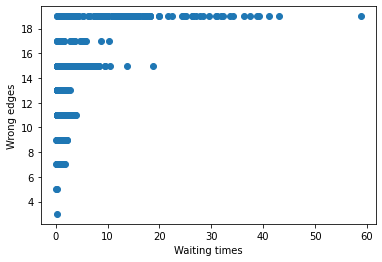

In [56]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")
plt.show()

plt.scatter(wait_times, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

G matrix changes (1 = changed, 0 = same)
count    1000.000000
mean        0.789000
std         0.408223
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


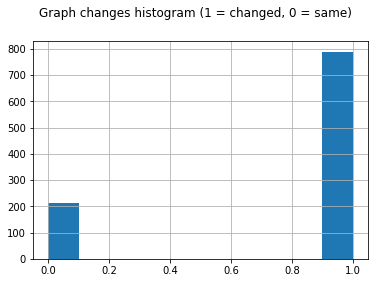

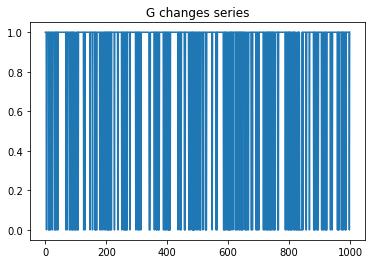

In [57]:
matrix_changes = pd.Series(graph_changes).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')
plt.show()

matrix_changes.plot(title='G changes series')
plt.show()

### Test without H sampler

Success: E transformed from Z
Success: C transformed from Z


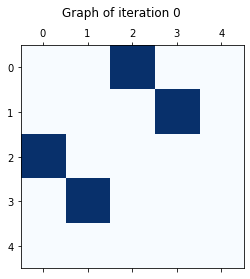

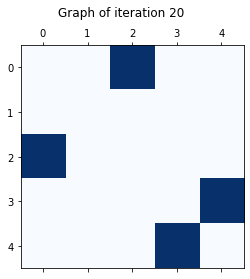

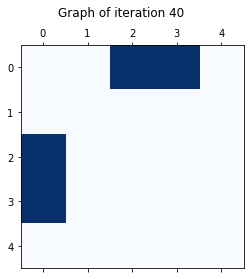

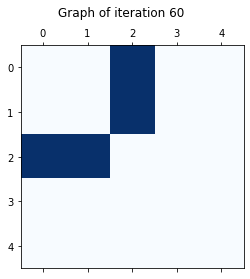

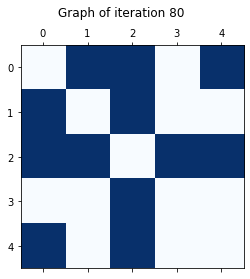

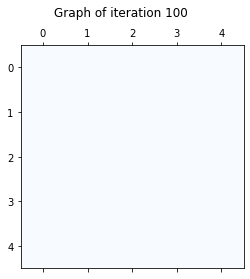

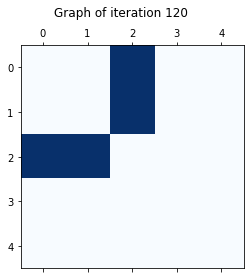

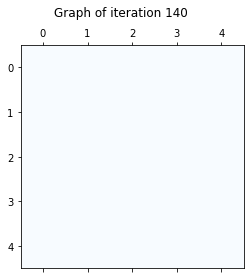

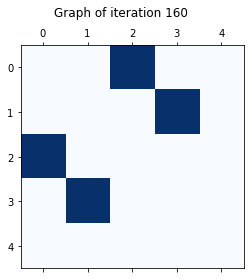

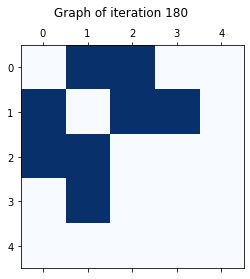

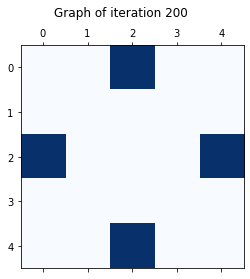

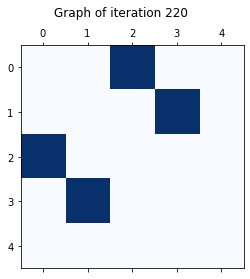

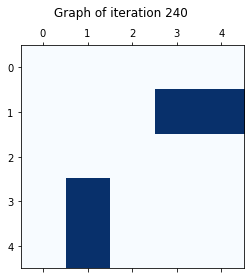

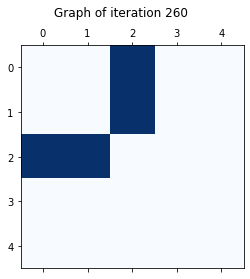

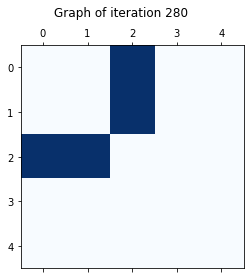

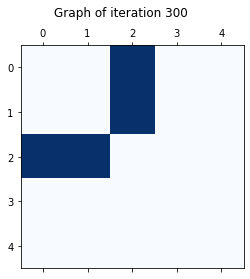

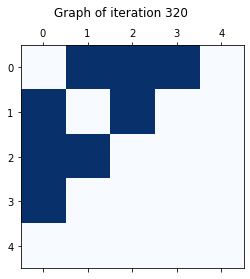

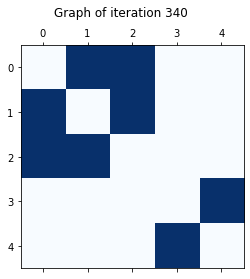

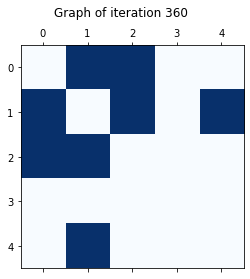

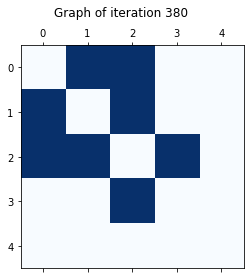

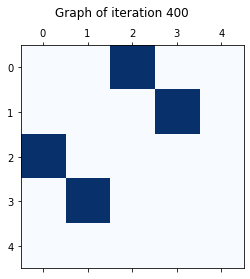

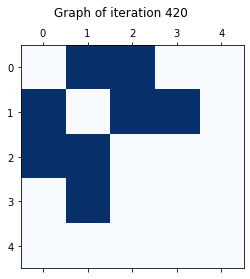

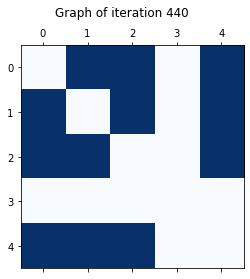

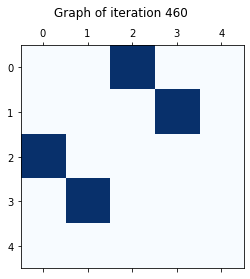

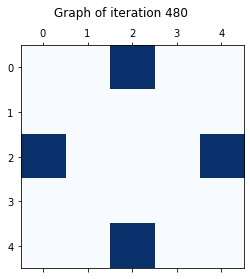

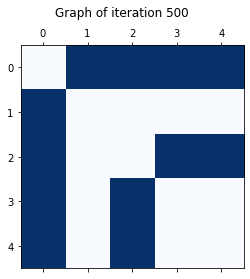

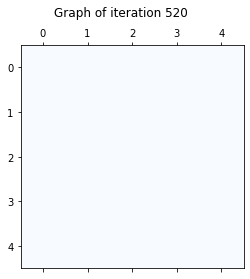

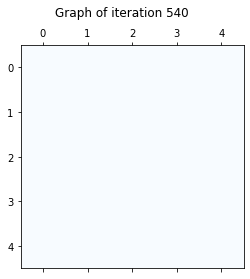

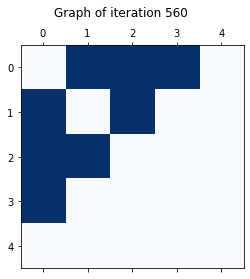

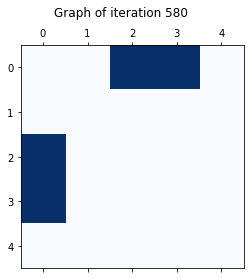

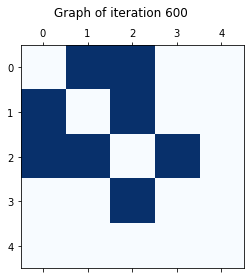

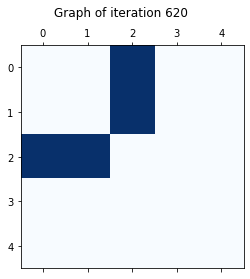

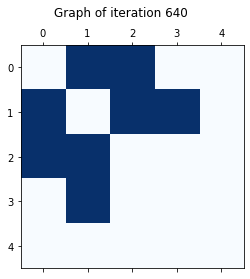

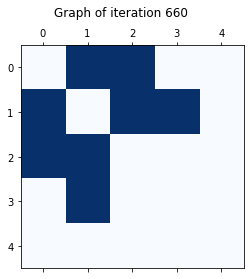

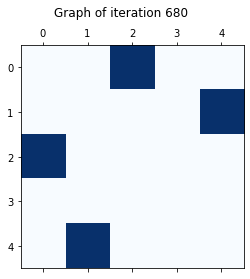

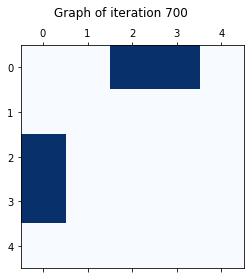

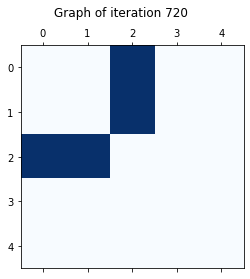

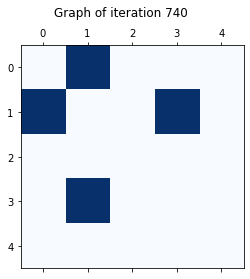

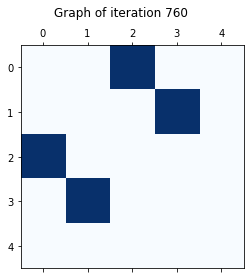

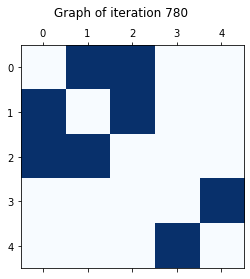

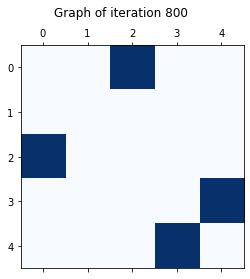

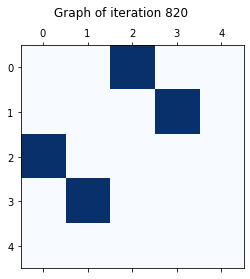

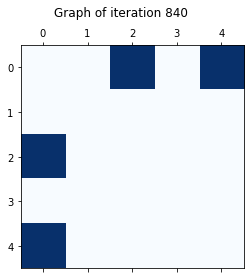

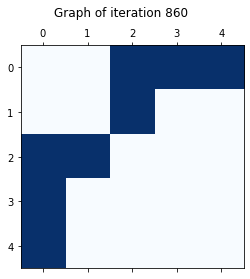

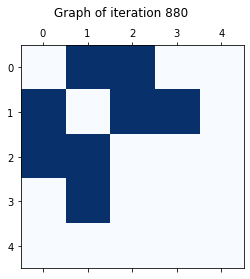

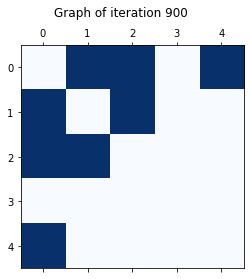

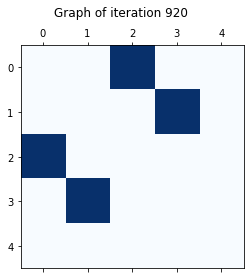

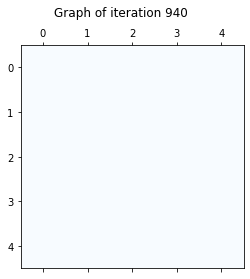

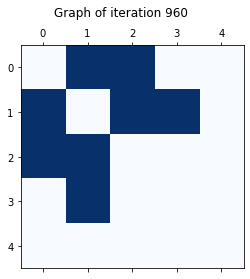

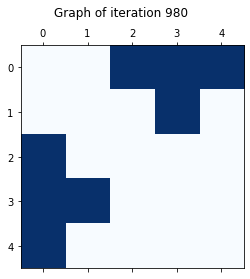

CPU times: user 2min 37s, sys: 24.1 s, total: 3min 1s
Wall time: 7min 20s


In [39]:
%%time
max_iterations = 1000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
G = initial.G.copy()

G_target = np.triu(simulated_data.G)  # BDgraph always returns upper triangular matrix. Our target matrix should be the same

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

# Skipping part
H = simulated_data.H.copy()
Theta = simulated_data.Theta.copy()

waiting_times = []
sampled_Gs = []
edges_log = []
errors_log = []
graph_changes = []

for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    #H = MC_sample_H(E, Sigma, H_current=H)
    #Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    wrong_edges = np.sum(G != G_target)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration%20==0:  # Plot every 20 iterations
        plt.matshow(G, cmap='Blues')
        plt.suptitle("Graph of iteration "+str(iteration), x=0.5, y=1, ha='center')
        plt.show()

Wrong edges metrics
count    1000.000000
mean        4.560000
std         2.379088
min         1.000000
25%         3.000000
50%         3.000000
75%         7.000000
max        11.000000
dtype: float64


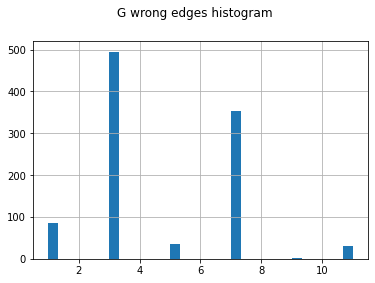

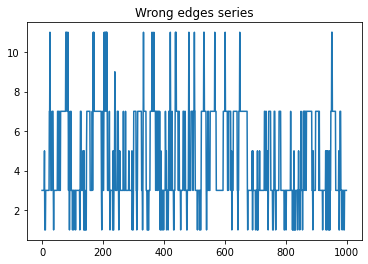

In [40]:
wrong_edges = pd.Series(edges_log)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')
plt.show()

wrong_edges.plot(title="Wrong edges series")
plt.show()

Sigma errors metrics
count    1000.000000
mean       24.784932
std        10.987467
min         8.080262
25%        17.641047
50%        22.380997
75%        28.931557
max       130.408565
dtype: float64


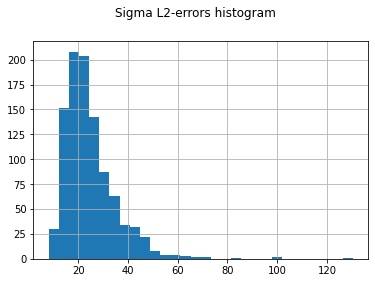

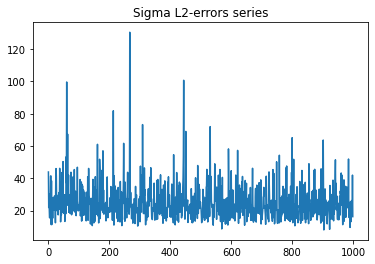

In [41]:
Sigma_errors = pd.Series(errors_log)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')
plt.show()

Sigma_errors.plot(title="Sigma L2-errors series")
plt.show()

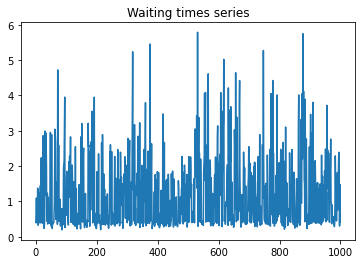

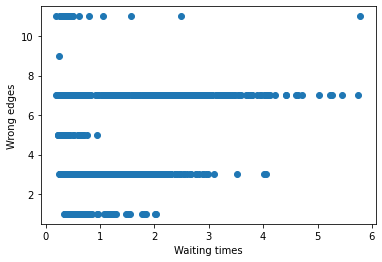

In [42]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")
plt.show()

plt.scatter(wait_times, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

G matrix changes (1 = changed, 0 = same)
count    1000.000000
mean        0.779000
std         0.415128
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


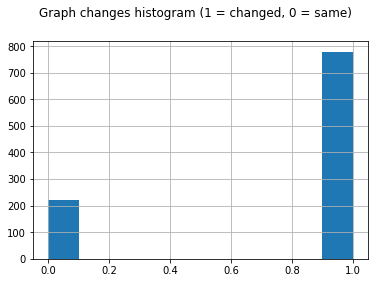

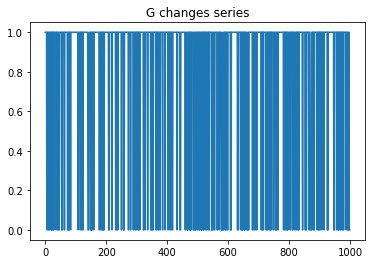

In [43]:
matrix_changes = pd.Series(graph_changes).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')
plt.show()

matrix_changes.plot(title='G changes series')
plt.show()

### Global sampler

Success: E transformed from Z
Success: C transformed from Z


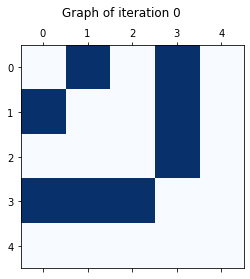

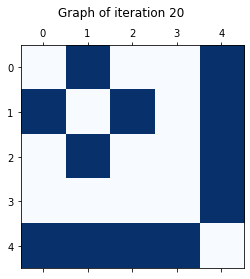

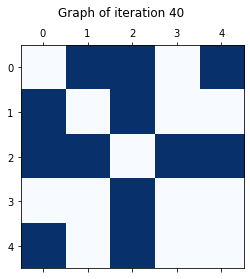

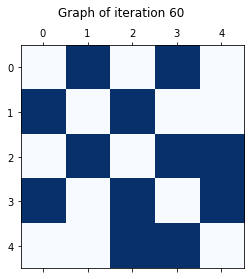

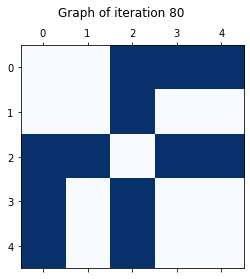

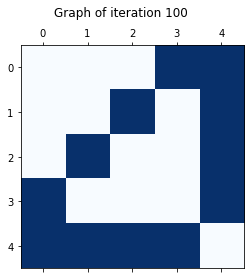

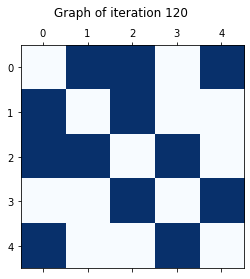

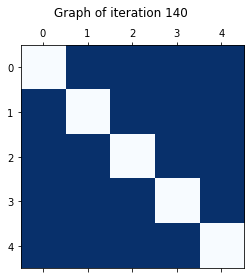

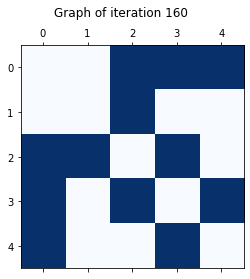

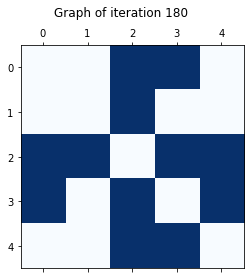

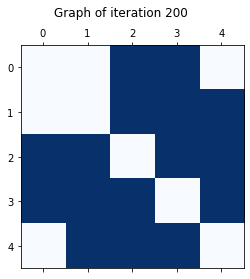

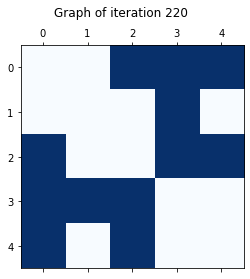

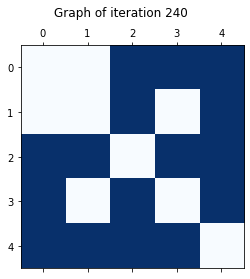

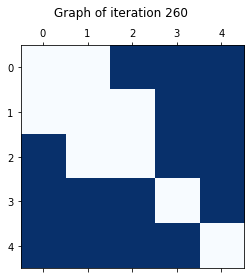

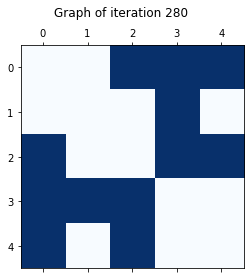

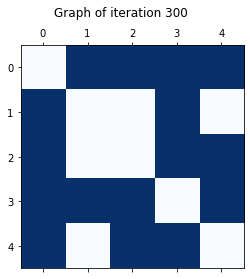

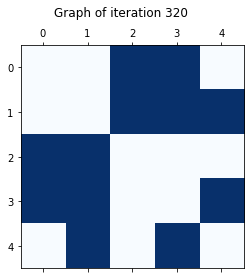

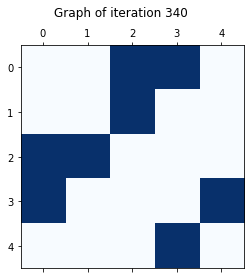

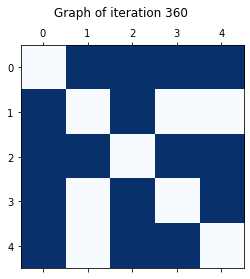

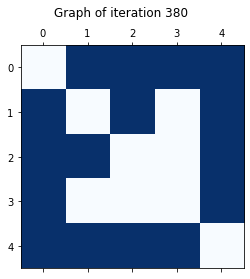

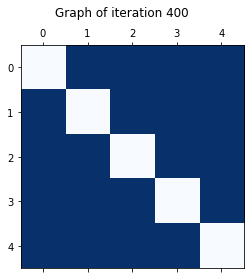

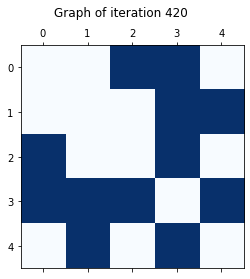

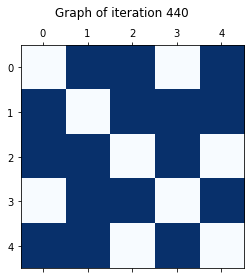

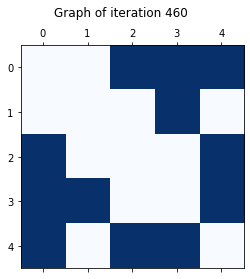

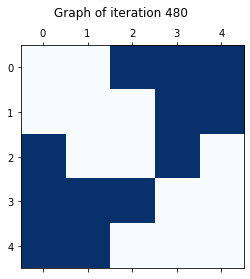

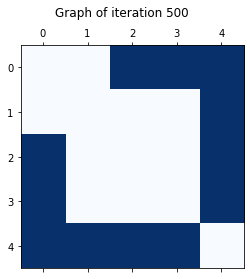

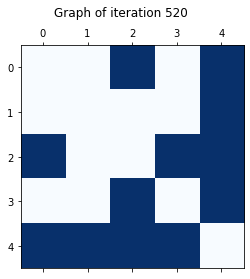

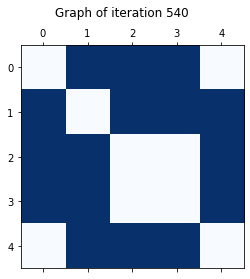

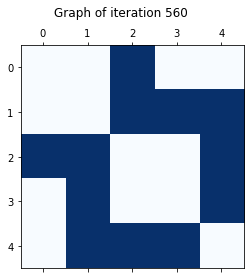

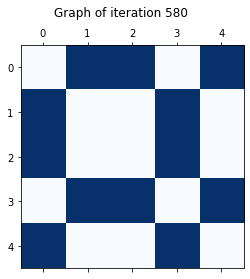

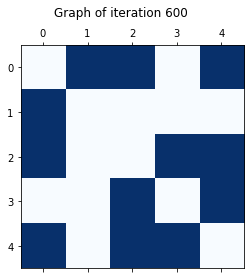

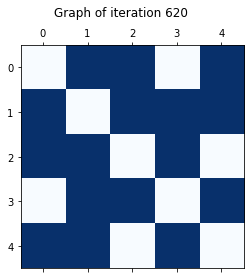

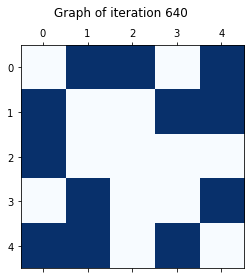

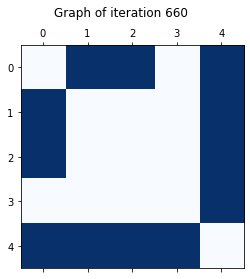

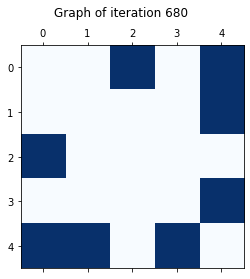

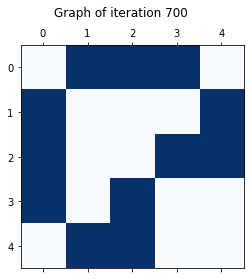

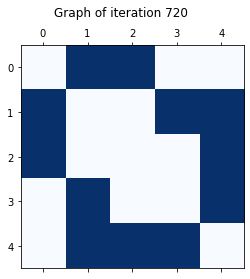

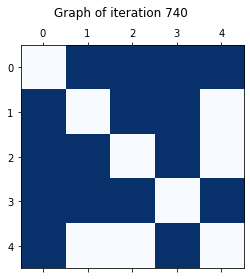

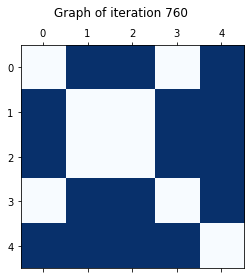

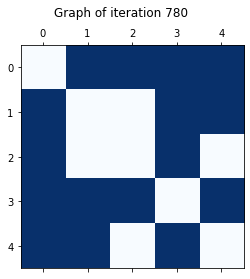

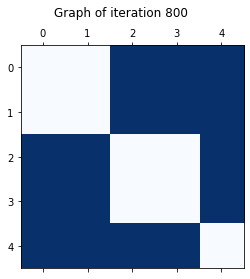

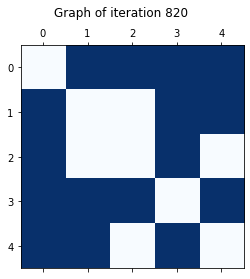

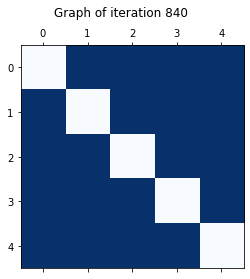

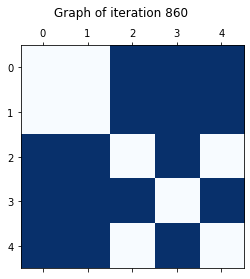

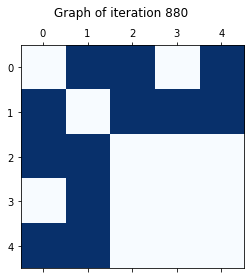

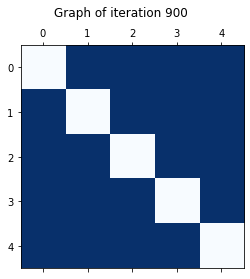

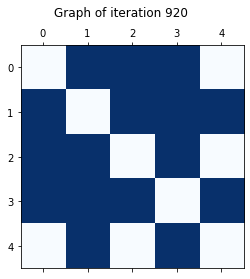

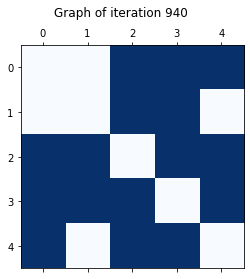

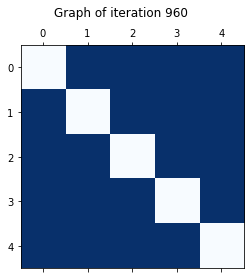

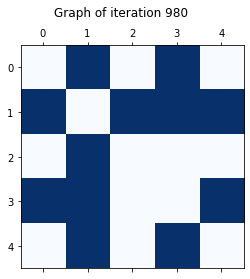

CPU times: user 3min 42s, sys: 30.2 s, total: 4min 12s
Wall time: 8min 15s


In [63]:
%%time
max_iterations = 1000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

G_target = np.triu(simulated_data.G)  # BDgraph always returns upper triangular matrix. Our target matrix should be the same

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

H = None

waiting_times = []
sampled_Gs = []
edges_log = []
errors_log = []
graph_changes = []

for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma, H_current=H, burn_in=15)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    wrong_edges = np.sum(G != G_target)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration%20==0:  # Plot every 20 iterations
        plt.matshow(G, cmap='Blues')
        plt.suptitle("Graph of iteration "+str(iteration), x=0.5, y=1, ha='center')
        plt.show()

Wrong edges metrics
count    1000.000000
mean       13.432000
std         2.921286
min         7.000000
25%        11.000000
50%        15.000000
75%        15.000000
max        19.000000
dtype: float64


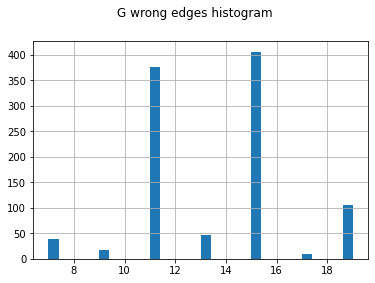

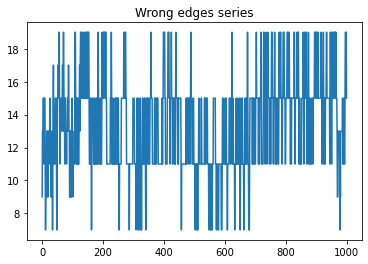

In [64]:
wrong_edges = pd.Series(edges_log)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')
plt.show()

wrong_edges.plot(title="Wrong edges series")
plt.show()

Sigma errors metrics
count    1000.000000
mean       24.132906
std        15.740518
min         1.877551
25%        14.250988
50%        20.414719
75%        30.310892
max       179.206781
dtype: float64


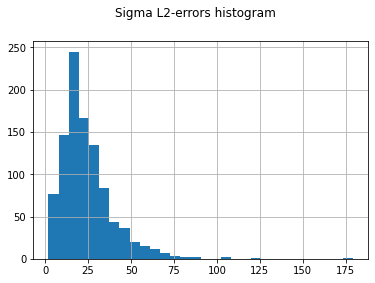

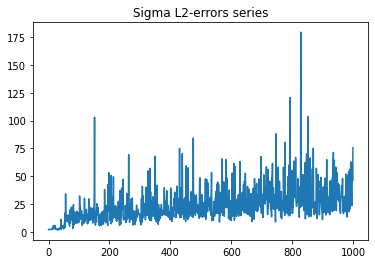

In [65]:
Sigma_errors = pd.Series(errors_log)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')
plt.show()

Sigma_errors.plot(title="Sigma L2-errors series")
plt.show()

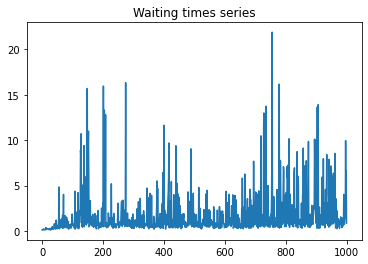

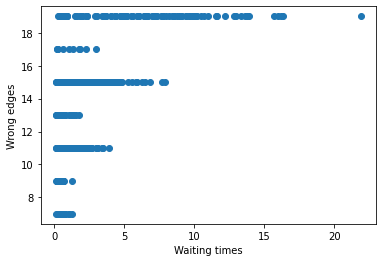

In [66]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")
plt.show()

plt.scatter(wait_times, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

G matrix changes (1 = changed, 0 = same)
count    1000.000000
mean        0.824000
std         0.381011
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


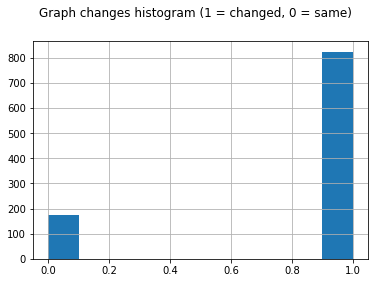

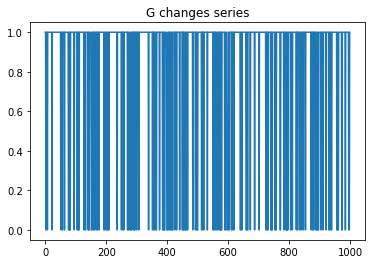

In [67]:
matrix_changes = pd.Series(graph_changes).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')
plt.show()

matrix_changes.plot(title='G changes series')
plt.show()